In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../TileEM/

/home/jlee782/crowd-seg/analysis/TileEM


In [3]:
from TileEM_plot_toolbox import *
from qualityBaseline import *
from glob import glob

In [4]:
worker_Nbatches={5:10,10:8,15:6,20:4,25:2,30:1}
sampleN_lst=worker_Nbatches.keys()
Nsample_lst = worker_Nbatches.keys()

# Dataset Characterization 

- CITE previous literature show three types of error : worker response can identify the wrong object (ambiguous), low-precision BBs (sloppy), underdraw/overdraw. 
	\todo[inline]{- basic characterization of our dataset to show that the worker responses are indeed noisy} 
		- stats: \% overdraw and underdraw
		- variance in ground truth P,R 

In [5]:
len(load_info())

4

In [6]:
img_info,object_tbl,bb_info,hits_info = load_info()

In [64]:
underbounding_lst=[]
overbounding_lst=[]
bb_area_lst =[]
diff_area_lst = []
my_BBG  = pd.read_csv("my_ground_truth.csv")
#for bb in tqdm(list(bb_info.iterrows())):
for objid in tqdm(object_lst):
    bb_obj=bb_info[bb_info["object_id"]==objid]
    underbounding=0
    overbounding=0
    for bb in list(bb_obj.iterrows()):
        objid = bb[1]["object_id"]

        #Image information 
        image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
        img_name = img_info["filename"][image_id-1]

        bbx_path= bb[1]["x_locs"]
        bby_path= bb[1]["y_locs"]
        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
        bb = Polygon(zip(worker_x_locs,worker_y_locs))

        ground_truth_match = my_BBG[my_BBG.object_id==objid]
        x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
        BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))

        if bb.area< BBG.area:
            underbounding+=1
        else: 
            overbounding+=1
        bb_area_lst.append(bb.area)
        diff_area_lst.append(bb.area-BBG.area)
    underbounding_lst.append(underbounding)
    overbounding_lst.append(overbounding)

In [53]:
underbounding_lst=np.array(underbounding_lst,dtype=float)
overbounding_lst=np.array(overbounding_lst,dtype=float)

In [60]:
underbounding_rate = underbounding_lst/(underbounding_lst+overbounding_lst)
overbounding_rate = overbounding_lst/(underbounding_lst+overbounding_lst)
print "underbounding rate:" ,mean(underbounding_rate), std(underbounding_rate)
print "overbounding rate:" , mean(overbounding_rate), std(overbounding_rate)

underbounding rate: 0.496514253763 0.270778411512
overbounding rate: 0.503485746237 0.270778411512


(array([ 7.,  5.,  4.,  5.,  2.,  9.,  4.,  3.,  4.,  4.]),
 array([ 0.075 ,  0.1675,  0.26  ,  0.3525,  0.445 ,  0.5375,  0.63  ,
         0.7225,  0.815 ,  0.9075,  1.    ]),
 <a list of 10 Patch objects>)

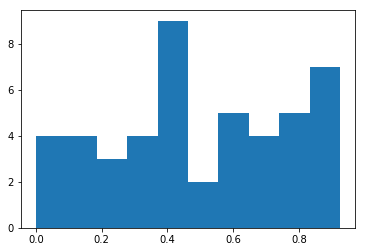

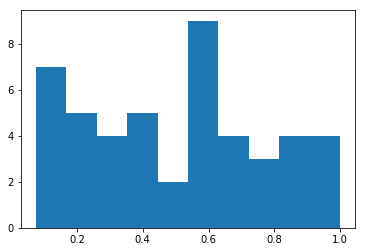

In [62]:
plt.hist(underbounding_rate)
plt.figure()
plt.hist(overbounding_rate)

In [43]:
underbounding

914

In [44]:
overbounding

914

In [26]:
len(list(bb_info.iterrows()))

1828

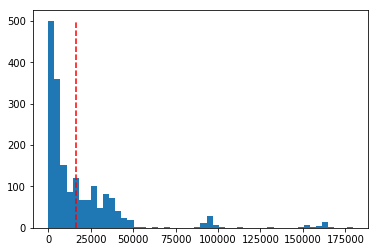

In [39]:
a = plt.hist(bb_area_lst,bins=50)
plt.vlines(BBG.area,0,500,'red','--')

The rate at which people underbound and overbound is around 50%-50% with a variance of around 25%. The degree to which workers overbound is larger for the overbounding case than the underbounding case. 

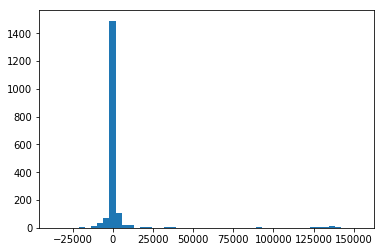

In [68]:
a = plt.hist(diff_area_lst,bins=50)

In [71]:
diff_area = np.array(diff_area_lst)

In [79]:
print "On average workers overbound by A=",mean(diff_area[np.where(diff_area>0)[0]])
print "On average workers underbound by A=",mean(diff_area[np.where(diff_area<0)[0]])
print "Median workers overbound by A=",median(diff_area[np.where(diff_area>0)[0]])
print "Median workers underbound by A=",median(diff_area[np.where(diff_area<0)[0]])

On average workers overbound by A= 7212.04552483
On average workers underbound by A= -1306.42940165
Median workers overbound by A= 419.25
Median workers underbound by A= -388.25


# Data Cleaning 

In [110]:
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

In [158]:
def data_clean(df):
    df = df.rename(index=str,columns={'P [Jaccard [Self]]':'P [GT Jaccard]','R [Jaccard [Self]]':'R [GT Jaccard]',\
                             'P [Precision [Self]]':'P [GT Precision]','R [Precision [Self]]':'R [GT Precision]',\
                             'P [Recall [Self]]':'P [GT Recall]','R [Recall [Self]]':'R [GT Recall]',\
                            })
    return df

In [128]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [132]:
!head sample/5worker_rand0/GT_PR.csv

,object_id,GT Tile-based Precision,GT Tile-based Recall,GT A_thres
0,1.0,0.855648597987,0.0137677108438,8.55574936081
1,2.0,0.962618197179,0.988098861007,8.65030551591
2,3.0,0.939695634287,0.0953050511189,12.0998322968
3,4.0,0.969633047666,0.942834706765,12.6494919022
4,5.0,0.951914039969,0.932063870362,9.46507853613
5,6.0,0.961494644526,0.900493208855,1.20887445887
6,7.0,0.949913341055,0.582125183454,13.9084555858
7,8.0,0.959388054276,0.939566305633,38.3304901577
8,9.0,0.986354695668,0.965070369103,8.48617570338


In [145]:
df.to_csv

In [139]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


Working on : 10worker_rand6
C error crashed so no GT_PR table created

In [201]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [204]:
df = df.merge(PR_tbl[["object_id","P [GT Tile-based]","R [GT Tile-based]"]],on="object_id")

In [219]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [251]:
PR_tbl = pd.read_csv("GT_PR.csv",index_col=0)

In [271]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [326]:
for Nworker in sampleN_lst:
    for batch_num in range(worker_Nbatches[Nworker]):
        dir_name = "{0}worker_rand{1}".format(Nworker,batch_num)
        df = pd.read_csv("sample/"+dir_name+"/PR_tbl_all.csv",index_col=0)
        df=data_clean(df)
        print "Working on :", dir_name
        os.chdir("sample/"+dir_name)
        try:
            PR_tbl = pd.read_csv("GT_PR.csv",index_col=0)
            
            visionPR = pd.read_csv("../../PR.csv")
            PR_tbl["P [Vision GT 50%]"] = visionPR["precision"]
            PR_tbl["R [Vision GT 50%]"] = visionPR["recall"]
            PR_tbl = PR_tbl.rename(index=str,columns={'GT Tile-based Precision':'P [GT Tile-based]','GT Tile-based Recall':'R [GT Tile-based]'})
            df = df.drop(["P [Vision GT 50%]","R [Vision GT 50%]"],axis=1)
            df = df.merge(PR_tbl[["object_id","P [GT Tile-based]","R [GT Tile-based]","P [Vision GT 50%]","R [Vision GT 50%]"]],on="object_id")
            df.to_csv("PR_tbl_updated.csv")
        except(IOError):
            print dir_name+"failed"
            pass 
        
        os.chdir("../../")

Working on : 5worker_rand0
Working on : 5worker_rand1
Working on : 5worker_rand2
Working on : 5worker_rand3
Working on : 5worker_rand4
Working on : 5worker_rand5
Working on : 5worker_rand6
Working on : 5worker_rand7
Working on : 5worker_rand8
Working on : 5worker_rand9
Working on : 10worker_rand0
Working on : 10worker_rand1
Working on : 10worker_rand2
Working on : 10worker_rand3
Working on : 10worker_rand4
Working on : 10worker_rand5
Working on : 10worker_rand6
10worker_rand6failed
Working on : 10worker_rand7
Working on : 15worker_rand0
Working on : 15worker_rand1
Working on : 15worker_rand2
Working on : 15worker_rand3
Working on : 15worker_rand4
Working on : 15worker_rand5
Working on : 20worker_rand0
Working on : 20worker_rand1
Working on : 20worker_rand2
Working on : 20worker_rand3
Working on : 25worker_rand0
Working on : 25worker_rand1
Working on : 30worker_rand0


In [327]:
from bad_vtiles import *

In [329]:
# elif mode =="aggregate_sample_table" :
sampleN_lst=sorted(worker_Nbatches.keys())

for Nworker in sampleN_lst:
    print "Working on worker = ",Nworker
    batch_all_data=[]
    for batch_num in range(worker_Nbatches[Nworker]):
        dir_name = "sample/{0}worker_rand{1}".format(Nworker,batch_num)
        try:
            batch_i_data=pd.read_csv(dir_name+"/PR_tbl_updated.csv",index_col=0)
            #Drop the object rows where the objects have bad vtiles to begin with
            bad_vtile_objs = list(problematic[(problematic["Nworker"]==Nworker)&(problematic["batch_num"]==batch_num)].objid)
            bad_vtile_objs.extend([35,41]) # Discard ambiguous objects
            batch_i_data=batch_i_data.drop(bad_vtile_objs,errors='ignore')
            #batch_i_data[~batch_i_data["object_id"].isin(bad_vtile_objs)]
            # First set the object_id column the index, then reindex based on this index to correspond to object lst
            # This fills in a row of NaN for the missing data objects, so it normalizes the shape of our data table
            batch_i_data = batch_i_data.set_index('object_id').reindex(object_lst,fill_value =0)
             # Add a row of non-nan count for averaging
            nan_rowidx= list(batch_i_data[batch_i_data["P [Num Points]"]==0].index)
            non_nan_count = np.ones_like(object_lst)
            #non_nan_count = np.ones(47)
            for row in nan_rowidx: non_nan_count[row-1]=0
            batch_i_data["non_nan_count"]=non_nan_count
            if batch_num==0:
                batch_all_data=batch_i_data
            else:
                batch_all_data+=batch_i_data
        except(IOError):
            print dir_name+"failed"
            pass 
    try:
        batch_all_data=batch_all_data[batch_all_data.keys()[:-1]].divide(batch_all_data["non_nan_count"],axis=0)
        batch_all_data[batch_all_data>1]=1
        batch_all_data[batch_all_data<0]=0
        print "Created sample{}_PR.csv".format(Nworker)
        batch_all_data.to_csv("sample{}_PR.csv".format(Nworker))
    except(ZeroDivisionError):
        print "No data for worker=",Nworker

Working on worker =  5
Created sample5_PR.csv
Working on worker =  10
sample/10worker_rand6failed
Created sample10_PR.csv
Working on worker =  15
Created sample15_PR.csv
Working on worker =  20
Created sample20_PR.csv
Working on worker =  25
Created sample25_PR.csv
Working on worker =  30
Created sample30_PR.csv



# Sample 5 worker 

In [275]:
'P [GT Tile-based]', u'R [GT Tile-based]'

Index([u'object_id', u'P [Num Points]', u'R [Num Points]', u'P [Area Ratio]',
       u'R [Area Ratio]', u'P [GT Jaccard]', u'R [GT Jaccard]',
       u'P [GT Precision]', u'R [GT Precision]', u'P [GT Recall]',
       u'R [GT Recall]', u'P [Vision Best Area Ratio 50%]',
       u'R [Vision Best Area Ratio 50%]', u'P [Vision Best Num Points 50%]',
       u'R [Vision Best Num Points 50%]', u'P [Vision GT 10%]',
       u'R [Vision GT 10%]', u'P [Vision GT 90%]', u'R [Vision GT 90%]',
       u'P [TileEM]', u'R [TileEM]', u'P [MVT]', u'R [MVT]', u'P [MVTtop10]',
       u'R [MVTtop10]', u'P [MVTtop95%]', u'R [MVTtop95%]',
       u'P [GT Tile-based]', u'R [GT Tile-based]', u'P [Vision GT 50%]',
       u'R [Vision GT 50%]'],
      dtype='object')

In [298]:
attr_lst = ['Num Points','Area Ratio','GT Jaccard','GT Precision','GT Recall',
            'Vision Best Area Ratio 50%','Vision Best Num Points 50%','Vision GT 10%','Vision GT 10%',\
            'Vision GT 50%','Vision GT 90%','GT Tile-based',\
            'TileEM','MVT','MVTtop10','MVTtop95%']
selected_attr_lst = ['Num Points','Area Ratio','TileEM','MVT','GT Tile-based','GT Precision','GT Recall','GT Jaccard',\
                     'Vision Best Area Ratio 50%','Vision Best Num Points 50%','Vision GT 50%']

selected_col_lst =[]
for attr in selected_attr_lst:
    selected_col_lst.append("P [{}]".format(attr))
    selected_col_lst.append("R [{}]".format(attr))

P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.917714
R [GT Tile-based]                 0.786388
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

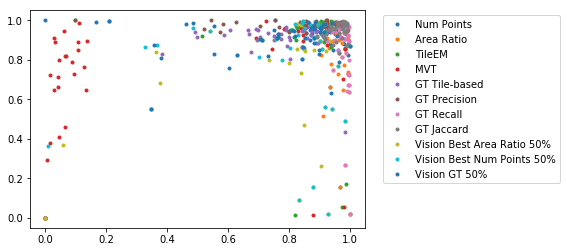

In [313]:
Nsample=5
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()

P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.904896
R [GT Tile-based]                 0.544933
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

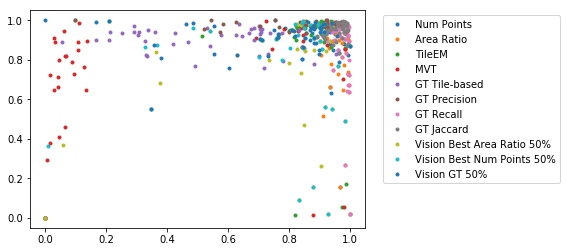

In [314]:
Nsample=10
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()

P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.928452
R [GT Tile-based]                 0.478816
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

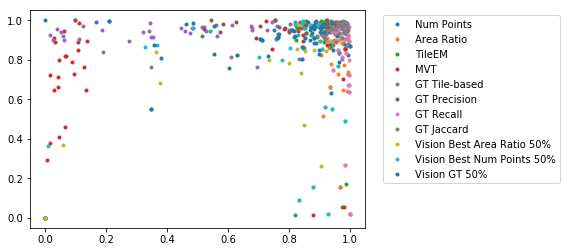

In [315]:
Nsample=15
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()


P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.892243
R [GT Tile-based]                 0.398061
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

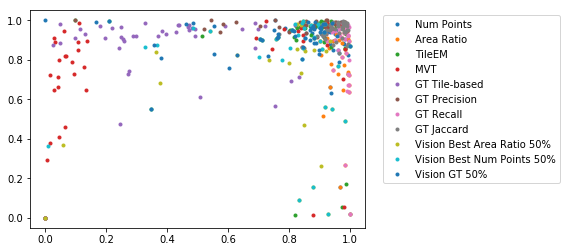

In [290]:
Nsample=20
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()


P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.899385
R [GT Tile-based]                 0.369982
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

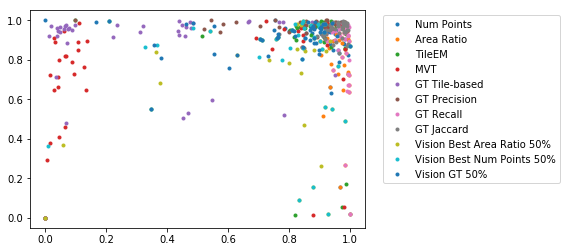

In [291]:
Nsample=25
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()


P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.902697
R [GT Tile-based]                 0.265966
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

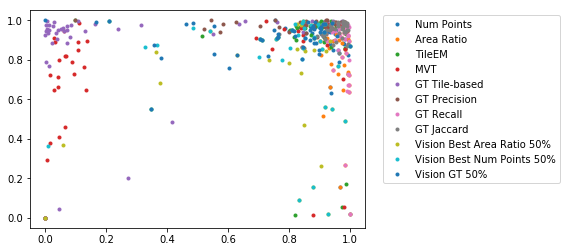

In [292]:
Nsample=30
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()


Metrics used in Irshad et al 

$$sensitivity = TPR = \frac{|A(T)\bigcap A(S)|}{|A(T)|} = recall $$
$$specificity = TNR = \frac{|A(I)-(A(T)\bigcup A(S))|}{|A(I)-A(T)|}$$
$$ F1 measure = 2*\frac{P*R}{P+R}$$

Upper limit to vision 

In [331]:
from tabulate import tabulate

In [332]:
df_all = pd.DataFrame()
cols  = []
for Nsample in sorted(Nsample_lst):
    df = pd.read_csv("sample{}_PR.csv".format(Nsample))
    df=data_clean(df)
    cols.append(Nsample)
    df_all[Nsample]=df[selected_col_lst].mean()

In [333]:
pd.options.display.float_format = '{:,.3f}'.format

In [334]:
#reordering columns so that sort by category + limit 
df_all.reindex([u'P [Num Points]', u'R [Num Points]', u'P [Area Ratio]',
               u'R [Area Ratio]',u'P [GT Precision]', u'R [GT Precision]', u'P [GT Recall]',
               u'R [GT Recall]',u'P [GT Jaccard]', u'R [GT Jaccard]', u'P [TileEM]', u'R [TileEM]', u'P [MVT]', u'R [MVT]',u'P [GT Tile-based]'
               ,u'R [GT Tile-based]', u'P [Vision Best Area Ratio 50%]',
               u'R [Vision Best Area Ratio 50%]', u'P [Vision Best Num Points 50%]',
               u'R [Vision Best Num Points 50%]', u'P [Vision GT 50%]',
               u'R [Vision GT 50%]'])

,5,10,15,20,25,30
P [Num Points],0.856,0.847,0.826,0.833,0.862,0.890
R [Num Points],0.890,0.881,0.888,0.897,0.919,0.938
P [Area Ratio],0.787,0.738,0.696,0.676,0.619,0.720
R [Area Ratio],0.910,0.913,0.908,0.894,0.891,0.933
P [GT Precision],0.927,0.934,0.937,0.938,0.954,0.985
R [GT Precision],0.836,0.814,0.807,0.801,0.817,0.846
P [GT Recall],0.837,0.822,0.801,0.797,0.786,0.845
R [GT Recall],0.923,0.934,0.939,0.941,0.961,0.989
P [GT Jaccard],0.910,0.916,0.917,0.917,0.934,0.967
R [GT Jaccard],0.907,0.913,0.916,0.918,0.937,0.966


In [301]:
PR = pd.read_csv("sample/10worker_rand0/PR_tbl_all.csv")

In [188]:
PR[PR["object_id"]==40]

,Unnamed: 0,object_id,P [Num Points],R [Num Points],P [Area Ratio],R [Area Ratio],P [Jaccard [Self]],R [Jaccard [Self]],P [Precision [Self]],R [Precision [Self]],...,P [Vision GT 90%],R [Vision GT 90%],P [TileEM],R [TileEM],P [MVT],R [MVT],P [MVTtop10],R [MVTtop10],P [MVTtop95%],R [MVTtop95%]
37,37,40,0.019005,1,0.019005,1,0.931817,0.766411,0.969952,0.704208,...,1,0.050533,0.01569,0.819621,0.016797,0.878719,0.013302,0.692692,0.011176,0.580713


In [179]:
Tstar = pkl.load(open("sample/10worker_rand0/Tstar_obj40.pkl"))

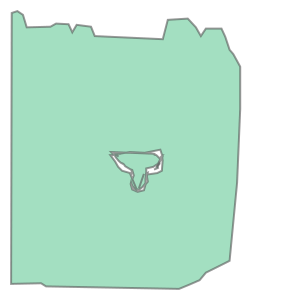

In [181]:
Tstar[0][0]

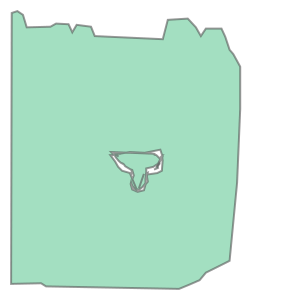

In [182]:
Tstar[-1][0]

In [165]:
# df_all.index

In [195]:
print tabulate(df_all,floatfmt=".2f",showindex=True,headers="keys",tablefmt="latex")

\begin{tabular}{lrrrrrr}
\hline
                                &    5 &   10 &   15 &   20 &   25 &   30 \\
\hline
 P [Num Points]                 & 0.86 & 0.84 & 0.83 & 0.83 & 0.86 & 0.89 \\
 R [Num Points]                 & 0.89 & 0.88 & 0.89 & 0.90 & 0.92 & 0.94 \\
 P [Area Ratio]                 & 0.79 & 0.73 & 0.70 & 0.68 & 0.62 & 0.72 \\
 R [Area Ratio]                 & 0.91 & 0.91 & 0.91 & 0.89 & 0.89 & 0.93 \\
 P [TileEM]                     & 0.89 & 0.92 & 0.92 & 0.93 & 0.94 & 0.98 \\
 R [TileEM]                     & 0.85 & 0.86 & 0.86 & 0.82 & 0.79 & 0.83 \\
 P [MVT]                        & 0.82 & 0.82 & 0.79 & 0.77 & 0.77 & 0.86 \\
 R [MVT]                        & 0.72 & 0.56 & 0.46 & 0.35 & 0.35 & 0.28 \\
 P [GT Precision]               & 0.93 & 0.93 & 0.94 & 0.94 & 0.95 & 0.99 \\
 R [GT Precision]               & 0.84 & 0.81 & 0.81 & 0.80 & 0.82 & 0.85 \\
 P [GT Recall]                  & 0.84 & 0.82 & 0.80 & 0.80 & 0.79 & 0.85 \\
 R [GT Recall]                  & 0.9

In [378]:
for Nworker in sampleN_lst:
    for batch_num in range(worker_Nbatches[Nworker]):
        dir_name = "{0}worker_rand{1}".format(Nworker,batch_num)

In [382]:
dir_name="sample/5worker_rand0"

In [388]:
Tstar_idx_lst[niter]

[196]

In [418]:
Plst = []
Rlst = []
for Nworker in sampleN_lst:
    for batch_num in range(worker_Nbatches[Nworker]):
        dir_name = "sample/{0}worker_rand{1}".format(Nworker,batch_num)
        rand_objs = random.choice(object_lst,5)
        for objid in rand_objs:
            try:
                tiles = pkl.load(open(dir_name+"/vtiles{}.pkl".format(objid)))
                Tstar_idx_lst = pkl.load(open(dir_name+"/Tstar_idx_obj{}.pkl".format(objid)))
                p_lst=[]
                r_lst=[]
                for niter in range(len(Tstar_idx_lst)):
                    P,R = compute_PR(objid,np.array(Tstar_idx_lst[niter]),tiles)
                    p_lst.append(P)
                    r_lst.append(R)
                Plst.append(p_lst)
                Rlst.append(r_lst)
            except(IOError):
                print "skip",objid

TopologyException: found non-noded intersection between LINESTRING (509.815 232.78, 510 230) and LINESTRING (510 230, 510 230) at 509.99999999999989 230.00000000000202
TopologyException: found non-noded intersection between LINESTRING (506 211, 498 213.4) and LINESTRING (499.333 213, 501 213) at 499.33333333333343 213
TopologyException: found non-noded intersection between LINESTRING (434.471 283.694, 434.491 283.698) and LINESTRING (441 285, 433.5 283.5) at 434.48087460484095 283.69617492096819
TopologyException: found non-noded intersection between LINESTRING (440.395 290.034, 440.5 290.5) and LINESTRING (440.395 290.034, 440.473 290.381) at 440.45908911363841 290.31886655569019
TopologyException: found non-noded intersection between LINESTRING (432.2 283.24, 438.385 286.538) and LINESTRING (438.385 286.538, 434.429 284.429) at 434.55989531226072 284.4986108332057
TopologyException: side location conflict at 450 236
TopologyException: found non-noded intersection between LINESTRING (

TopologyException: found non-noded intersection between LINESTRING (479.556 162.667, 480.75 159.8) and LINESTRING (479 162, 479.625 162.5) at 479.625 162.5
Self-intersection at or near point 479.625 162.5
TopologyException: found non-noded intersection between LINESTRING (479.556 162.667, 480.75 159.8) and LINESTRING (479 162, 479.625 162.5) at 479.625 162.5
Self-intersection at or near point 479.625 162.5
TopologyException: found non-noded intersection between LINESTRING (479.556 162.667, 480.75 159.8) and LINESTRING (479 162, 479.625 162.5) at 479.625 162.5
Self-intersection at or near point 479.625 162.5
TopologyException: found non-noded intersection between LINESTRING (479.556 162.667, 480.75 159.8) and LINESTRING (479 162, 479.625 162.5) at 479.625 162.5
Self-intersection at or near point 479.625 162.5
TopologyException: found non-noded intersection between LINESTRING (479.556 162.667, 480.75 159.8) and LINESTRING (479 162, 479.625 162.5) at 479.625 162.5
Self-intersection at or 

TopologyException: found non-noded intersection between LINESTRING (60.2906 324.333, 50.8779 318.54) and LINESTRING (59.9964 324.152, 59.9273 324.109) at 59.983504342840199 324.14369498020937
TopologyException: found non-noded intersection between LINESTRING (60.2906 324.333, 50.8779 318.54) and LINESTRING (59.9964 324.152, 59.9273 324.109) at 59.983504342840199 324.14369498020937
TopologyException: found non-noded intersection between LINESTRING (60.2906 324.333, 50.8779 318.54) and LINESTRING (59.9964 324.152, 59.9273 324.109) at 59.983504342840199 324.14369498020937
TopologyException: no outgoing dirEdge found at 199.49546827794563 508.80060422960725
TopologyException: side location conflict at 35.333333329471998 105.666666658944
TopologyException: found non-noded intersection between LINESTRING (218.038 547.077, 245.317 594.611) and LINESTRING (199.495 508.801, 245.987 595.867) at 245.31673582295986 594.61134163208851
TopologyException: found non-noded intersection between LINESTRI

TopologyException: found non-noded intersection between LINESTRING (47 207, 81.5288 205.767) and LINESTRING (75.2728 205.99, 85.0508 205.641) at 79.573005041279231 205.83667839138289
TopologyException: found non-noded intersection between LINESTRING (75.4766 205.983, 96.4468 205.234) and LINESTRING (96.4468 205.234, 96.4468 205.234) at 96.446808510638334 205.23404255319147
TopologyException: found non-noded intersection between LINESTRING (58.3514 206.595, 58.3514 206.595) and LINESTRING (64.4524 206.377, 58.3514 206.595) at 58.35135135135139 206.59459459459458
Self-intersection at or near point 64.452381264912788 206.37670066911025
TopologyException: found non-noded intersection between LINESTRING (96.4468 205.234, 100.846 205.077) and LINESTRING (101.139 204.191, 96.4468 205.234) at 96.446808510638363 205.23404255319147
TopologyException: found non-noded intersection between LINESTRING (47 207, 81.5288 205.767) and LINESTRING (75.2728 205.99, 85.0508 205.641) at 79.573005041279231 20

TopologyException: found non-noded intersection between LINESTRING (162 96, 154.511 99.0638) and LINESTRING (154.511 99.0638, 162.283 96.9912) at 154.51063829787245 99.063829787233999
TopologyException: found non-noded intersection between LINESTRING (47.4128 72.298, 49.7037 80.8889) and LINESTRING (47.5882 72.9558, 48.6667 77) at 47.844519305846383 73.916947396923916
TopologyException: found non-noded intersection between LINESTRING (162 96, 154.511 99.0638) and LINESTRING (154.511 99.0638, 162.283 96.9912) at 154.51063829787245 99.063829787233999
TopologyException: found non-noded intersection between LINESTRING (439 338.6, 439 338.6) and LINESTRING (439.815 334.852, 438 343.2) at 439 338.59999999999997
TopologyException: side location conflict at 496.19148936170211 210.95744680851064
TopologyException: found non-noded intersection between LINESTRING (415.818 265.416, 413.927 259.366) and LINESTRING (413.927 259.366, 415 265) at 413.92682926829269 259.36585365853671
TopologyException

TopologyException: found non-noded intersection between LINESTRING (407 357.8, 378.006 249.074) and LINESTRING (378.006 249.074, 383.444 267.246) at 378.00638910135592 249.07398462821584
Self-intersection at or near point 378.00638910135586 249.07398462821567
TopologyException: found non-noded intersection between LINESTRING (407 357.8, 378.006 249.074) and LINESTRING (378.006 249.074, 383.444 267.246) at 378.00638910135592 249.07398462821584
Self-intersection at or near point 378.00638910135586 249.07398462821567
TopologyException: found non-noded intersection between LINESTRING (407 357.8, 378.006 249.074) and LINESTRING (378.006 249.074, 383.444 267.246) at 378.00638910135592 249.07398462821584
Self-intersection at or near point 378.00638910135586 249.07398462821567
TopologyException: found non-noded intersection between LINESTRING (407 357.8, 378.006 249.074) and LINESTRING (378.006 249.074, 383.444 267.246) at 378.00638910135592 249.07398462821584
Self-intersection at or near poin

Self-intersection at or near point 307.14754098360658 73.426229508196727
TopologyException: side location conflict at 307.80838323353294 70.856287425149702
Self-intersection at or near point 307.14754098360658 73.426229508196727
TopologyException: side location conflict at 307.80838323353294 70.856287425149702
Self-intersection at or near point 307.14754098360658 73.426229508196727
TopologyException: side location conflict at 307.80838323353294 70.856287425149702
Self-intersection at or near point 307.14754098360658 73.426229508196727
TopologyException: side location conflict at 307.80838323353294 70.856287425149702
Self-intersection at or near point 307.14754098360658 73.426229508196727
TopologyException: side location conflict at 307.80838323353294 70.856287425149702
Self-intersection at or near point 307.14754098360658 73.426229508196727
TopologyException: side location conflict at 307.80838323353294 70.856287425149702
Self-intersection at or near point 307.14754098360658 73.4262295

Self-intersection at or near point 271 72
TopologyException: found non-noded intersection between LINESTRING (367.222 55.0741, 366.357 54.7857) and LINESTRING (368 63, 366.357 54.7857) at 366.35714285714283 54.785714285714285
Self-intersection at or near point 271 72
TopologyException: found non-noded intersection between LINESTRING (367.222 55.0741, 366.357 54.7857) and LINESTRING (368 63, 366.357 54.7857) at 366.35714285714283 54.785714285714285
Self-intersection at or near point 271 72
TopologyException: found non-noded intersection between LINESTRING (433 544, 550.458 466.881) and LINESTRING (539.454 473.169, 550.458 466.881) at 550.45762711864381 466.88135593220352
TopologyException: found non-noded intersection between LINESTRING (242 499, 239.6 499.8) and LINESTRING (243.301 498.181, 239.6 499.8) at 239.60000000000039 499.79999999999984
TopologyException: found non-noded intersection between LINESTRING (377.617 175.855, 393.274 175.229) and LINESTRING (394.329 175.187, 377.617 1

Self-intersection at or near point 555.66666666666674 96.999999999999929
TopologyException: found non-noded intersection between LINESTRING (555.964 96.4643, 555.72 96.904) and LINESTRING (555.964 96.4643, 555.677 96.9813) at 555.76255458861817 96.827401740487247
Self-intersection at or near point 555.66666666666674 96.999999999999929
TopologyException: found non-noded intersection between LINESTRING (555.964 96.4643, 555.72 96.904) and LINESTRING (555.964 96.4643, 555.677 96.9813) at 555.76255458861817 96.827401740487247
Self-intersection at or near point 555.66666666666674 96.999999999999929
TopologyException: found non-noded intersection between LINESTRING (555.964 96.4643, 555.72 96.904) and LINESTRING (555.964 96.4643, 555.677 96.9813) at 555.76255458861817 96.827401740487247
Self-intersection at or near point 555.66666666666674 96.999999999999929
TopologyException: found non-noded intersection between LINESTRING (555.964 96.4643, 555.72 96.904) and LINESTRING (555.964 96.4643, 55

Self-intersection at or near point 558.08791208791206 90.153846153846061
TopologyException: found non-noded intersection between LINESTRING (558.173 88.3654, 558.088 90.1538) and LINESTRING (559.81 85.3333, 558.088 90.1538) at 558.08791208791206 90.153846153846061
Self-intersection at or near point 558.08791208791206 90.153846153846061
TopologyException: found non-noded intersection between LINESTRING (558.173 88.3654, 558.088 90.1538) and LINESTRING (559.81 85.3333, 558.088 90.1538) at 558.08791208791206 90.153846153846061
Self-intersection at or near point 558.08791208791206 90.153846153846061
TopologyException: found non-noded intersection between LINESTRING (558.173 88.3654, 558.088 90.1538) and LINESTRING (559.81 85.3333, 558.088 90.1538) at 558.08791208791206 90.153846153846061
Self-intersection at or near point 558.08791208791206 90.153846153846061
TopologyException: found non-noded intersection between LINESTRING (558.173 88.3654, 558.088 90.1538) and LINESTRING (559.81 85.3333

TopologyException: found non-noded intersection between LINESTRING (511.588 226.882, 507.857 231.857) and LINESTRING (507.857 231.857, 509.46 229.38) at 507.85714285714329 231.85714285714226
TopologyException: found non-noded intersection between LINESTRING (50.8552 322.308, 52 322) and LINESTRING (52 322, 49.4 322.7) at 51.514296137330959 322.13076642456474
TopologyException: found non-noded intersection between LINESTRING (52 322, 52.4792 321.833) and LINESTRING (52.4792 321.833, 52.4792 321.833) at 52.479166666666664 321.83333333333331
TopologyException: found non-noded intersection between LINESTRING (155.995 636.443, 155.995 636.443) and LINESTRING (155.995 636.443, 155.995 636.443) at 155.99485066941219 636.44284243048401
TopologyException: side location conflict at 305.205607477 636.869158879
TopologyException: found non-noded intersection between LINESTRING (291.849 636.831, 291.464 636.83) and LINESTRING (235.632 636.67, 305.206 636.869) at 291.84242979916075 636.8309783708547

TopologyException: side location conflict at 305.205607477 636.869158879
TopologyException: found non-noded intersection between LINESTRING (291.849 636.831, 291.464 636.83) and LINESTRING (235.632 636.67, 305.206 636.869) at 291.84242979916075 636.83097837085472
TopologyException: found non-noded intersection between LINESTRING (297.182 636.592, 285.224 636.18) and LINESTRING (285.225 636.18, 298.145 636.626) at 285.2250943106277 636.18017566598382
TopologyException: found non-noded intersection between LINESTRING (248 383, 252.06 381.55) and LINESTRING (251.75 381.661, 247 382) at 251.74999999999994 381.66071428571428
TopologyException: found non-noded intersection between LINESTRING (248 383, 253.817 380.923) and LINESTRING (253.817 380.923, 251.75 381.661) at 252.12953194511857 381.52516716245765
TopologyException: found non-noded intersection between LINESTRING (41.0952 257.405, 38.5974 254.657) and LINESTRING (38.5974 254.657, 41.0952 257.405) at 39.696450216450167 255.8660952380

TopologyException: found non-noded intersection between LINESTRING (138.6 84.6, 139.924 86.8696) and LINESTRING (139.659 86.4153, 117 114) at 139.65889830513848 86.415254237380267
TopologyException: found non-noded intersection between LINESTRING (105.4 73.2, 105.02 75.226) and LINESTRING (105.4 73.2, 105.041 75.1168) at 105.31733819749337 73.640862946702029
TopologyException: found non-noded intersection between LINESTRING (91 55, 89.6743 58.1486) and LINESTRING (90.5897 55.9744, 94 55) at 90.589743589743591 55.974358974358971
TopologyException: found non-noded intersection between LINESTRING (22.8696 85.4348, 24 86) and LINESTRING (24 86, 26.0503 84.3598) at 24.000000000086004 85.999999999931191
TopologyException: found non-noded intersection between LINESTRING (25.2931 84.9655, 26.0503 84.3598) and LINESTRING (28.108 84.6344, 25.2931 84.9655) at 25.29310344827589 84.965517241379303
TopologyException: found non-noded intersection between LINESTRING (25.1364 85.0909, 24.813 85.3496) a

Self-intersection at or near point 464.32000000000005 218.23999999999953
TopologyException: found non-noded intersection between LINESTRING (464.32 218.24, 466 209) and LINESTRING (464.32 218.24, 465 206) at 464.32000000000005 218.23999999999953
Self-intersection at or near point 464.32000000000005 218.23999999999953
TopologyException: found non-noded intersection between LINESTRING (464.32 218.24, 466 209) and LINESTRING (464.32 218.24, 465 206) at 464.32000000000005 218.23999999999953
Self-intersection at or near point 464.32000000000005 218.23999999999953
TopologyException: found non-noded intersection between LINESTRING (464.32 218.24, 466 209) and LINESTRING (464.32 218.24, 465 206) at 464.32000000000005 218.23999999999953
Self-intersection at or near point 464.32000000000005 218.23999999999953
TopologyException: EdgeRing::computePoints: found null Directed Edge
TopologyException: found non-noded intersection between LINESTRING (31.377 363.421, 33.0155 365.253) and LINESTRING (30.

TopologyException: found non-noded intersection between LINESTRING (39.1387 172.664, 38 172) and LINESTRING (31.5 172, 39.1387 172.664) at 39.138686131386834 172.66423357664235
Self-intersection at or near point 39.138686131386869 172.66423357664235
TopologyException: found non-noded intersection between LINESTRING (39.1387 172.664, 38 172) and LINESTRING (31.5 172, 39.1387 172.664) at 39.138686131386834 172.66423357664235
Self-intersection at or near point 39.138686131386869 172.66423357664235
TopologyException: found non-noded intersection between LINESTRING (39.1387 172.664, 38 172) and LINESTRING (31.5 172, 39.1387 172.664) at 39.138686131386834 172.66423357664235
Self-intersection at or near point 39.138686131386869 172.66423357664235
TopologyException: found non-noded intersection between LINESTRING (39.1387 172.664, 38 172) and LINESTRING (31.5 172, 39.1387 172.664) at 39.138686131386834 172.66423357664235
Self-intersection at or near point 39.138686131386869 172.66423357664235


Self-intersection at or near point 3.5074626865672061 175.94776119402985
TopologyException: found non-noded intersection between LINESTRING (2.0141 176.396, 3.50746 175.948) and LINESTRING (3.50746 175.948, 1 176) at 3.5074626865671612 175.94776119402985
Self-intersection at or near point 3.5074626865672061 175.94776119402985
TopologyException: found non-noded intersection between LINESTRING (2.0141 176.396, 3.50746 175.948) and LINESTRING (3.50746 175.948, 1 176) at 3.5074626865671612 175.94776119402985
Self-intersection at or near point 3.5074626865672061 175.94776119402985
TopologyException: found non-noded intersection between LINESTRING (2.0141 176.396, 3.50746 175.948) and LINESTRING (3.50746 175.948, 1 176) at 3.5074626865671612 175.94776119402985
Self-intersection at or near point 3.5074626865672061 175.94776119402985
TopologyException: found non-noded intersection between LINESTRING (2.0141 176.396, 3.50746 175.948) and LINESTRING (3.50746 175.948, 1 176) at 3.5074626865671612

TopologyException: found non-noded intersection between LINESTRING (227.2 339.2, 228.861 340.861) and LINESTRING (229.636 341.636, 228.5 340.5) at 228.49999999999997 340.49999999999994
TopologyException: found non-noded intersection between LINESTRING (270.665 302.106, 268.861 301.696) and LINESTRING (268.861 301.696, 270.053 302.263) at 268.86086956521746 301.69565217391306
TopologyException: found non-noded intersection between LINESTRING (273.247 460.78, 275.231 465.124) and LINESTRING (283.026 465.755, 274.73 464.027) at 274.72972972972974 464.02702702702703
TopologyException: found non-noded intersection between LINESTRING (228.438 369.937, 228.287 369.066) and LINESTRING (228.8 367.4, 228 370) at 228.28729281767957 369.06629834254142
TopologyException: found non-noded intersection between LINESTRING (227.5 339.5, 229.316 341.316) and LINESTRING (229.316 341.316, 228.5 340.5) at 228.49999999999997 340.49999999999994
TopologyException: found non-noded intersection between LINESTRIN

Self-intersection at or near point 229.32432432432435 375.08108108108115
TopologyException: side location conflict at 229.32432432432429 375.08108108108087
Self-intersection at or near point 229.32432432432435 375.08108108108115
TopologyException: side location conflict at 229.32432432432429 375.08108108108087
Self-intersection at or near point 229.32432432432435 375.08108108108115
TopologyException: side location conflict at 229.32432432432429 375.08108108108087
Self-intersection at or near point 229.32432432432435 375.08108108108115
TopologyException: side location conflict at 229.32432432432429 375.08108108108087
Self-intersection at or near point 229.32432432432435 375.08108108108115
TopologyException: side location conflict at 229.32432432432429 375.08108108108087
Self-intersection at or near point 229.32432432432435 375.08108108108115
TopologyException: side location conflict at 229.32432432432429 375.08108108108087
Self-intersection at or near point 229.32432432432435 375.081081

TopologyException: found non-noded intersection between LINESTRING (273.247 460.78, 275.231 465.124) and LINESTRING (283.026 465.755, 274.73 464.027) at 274.72972972972974 464.02702702702703
TopologyException: found non-noded intersection between LINESTRING (273.247 460.78, 275.231 465.124) and LINESTRING (276.713 464.44, 274.73 464.027) at 274.72972972972974 464.02702702702703
TopologyException: found non-noded intersection between LINESTRING (273.247 460.78, 275.231 465.124) and LINESTRING (283.026 465.755, 274.73 464.027) at 274.72972972972974 464.02702702702703
TopologyException: found non-noded intersection between LINESTRING (228.438 369.937, 228.287 369.066) and LINESTRING (228.8 367.4, 228 370) at 228.28729281767957 369.06629834254142
TopologyException: found non-noded intersection between LINESTRING (227.5 339.5, 229.316 341.316) and LINESTRING (229.316 341.316, 228.5 340.5) at 228.49999999999997 340.49999999999994
TopologyException: found non-noded intersection between LINEST

Self-intersection at or near point 516.36474164133733 191.79635258358655
TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 516.365 191.796) and LINESTRING (516.221 190.695, 516.365 191.796) at 516.36474164133733 191.79635258358658
Self-intersection at or near point 516.36474164133733 191.79635258358655
TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 516.365 191.796) and LINESTRING (516.221 190.695, 516.365 191.796) at 516.36474164133733 191.79635258358658
Self-intersection at or near point 516.36474164133733 191.79635258358655
TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 516.365 191.796) and LINESTRING (516.221 190.695, 516.365 191.796) at 516.36474164133733 191.79635258358658
Self-intersection at or near point 516.36474164133733 191.79635258358655
TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 516.365 191.796) and LINESTRING (516.221 190

TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 516.365 191.796) and LINESTRING (516.221 190.695, 516.365 191.796) at 516.36474164133733 191.79635258358658
Self-intersection at or near point 516.36474164133733 191.79635258358655
TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 516.365 191.796) and LINESTRING (516.221 190.695, 516.365 191.796) at 516.36474164133733 191.79635258358658
Self-intersection at or near point 516.36474164133733 191.79635258358655
TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 516.365 191.796) and LINESTRING (516.221 190.695, 516.365 191.796) at 516.36474164133733 191.79635258358658
Self-intersection at or near point 516.36474164133733 191.79635258358655
TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 516.365 191.796) and LINESTRING (516.221 190.695, 516.365 191.796) at 516.36474164133733 191.79635258358658
Self-inte

TopologyException: found non-noded intersection between LINESTRING (516.365 191.796, 513.063 185.541) and LINESTRING (516.365 191.796, 516.221 190.695) at 516.36474164133733 191.7963525835865
TopologyException: found non-noded intersection between LINESTRING (289.455 205.727, 289.455 205.727) and LINESTRING (289.455 205.727, 289.455 205.727) at 289.45454545516645 205.72727272709531
TopologyException: found non-noded intersection between LINESTRING (530 241, 533.835 245.218) and LINESTRING (533.835 245.218, 533.286 244.929) at 533.83495145631059 245.21844660194168
TopologyException: found non-noded intersection between LINESTRING (293.252 190.822, 293.146 191.317) and LINESTRING (292.481 192.148, 293.363 191.046) at 293.14634146341461 191.3170731707317
TopologyException: found non-noded intersection between LINESTRING (513.063 185.541, 512.9 185.318) and LINESTRING (512.9 185.318, 514.824 187.941) at 512.95538241313886 185.39370329064394
TopologyException: found non-noded intersection b

TopologyException: side location conflict at 382.23212106115329 175.81179474405278
TopologyException: found non-noded intersection between LINESTRING (156.381 508.352, 166 492) and LINESTRING (157.467 506.507, 159.534 499.89) at 157.46666666666667 506.50666666666666
TopologyException: found non-noded intersection between LINESTRING (178.833 487.333, 177.967 487.581) and LINESTRING (178.25 487.5, 178.833 487.333) at 178.25772025424996 487.49779421307142
TopologyException: found non-noded intersection between LINESTRING (165.915 492.145, 157.467 506.507) and LINESTRING (156.381 508.352, 165.915 492.145) at 158.36338353005021 504.98224799891466
TopologyException: found non-noded intersection between LINESTRING (165.525 526.197, 164.944 526.612) and LINESTRING (165.127 526.481, 165.525 526.197) at 165.37901668785469 526.30070236581798
TopologyException: found non-noded intersection between LINESTRING (166.333 466.429, 163 465) and LINESTRING (163.75 465.875, 166.333 466.429) at 166.3333333

Self-intersection at or near point 150.03349282296659 525.3492822966507
TopologyException: found non-noded intersection between LINESTRING (150.249 525.359, 150.033 525.349) and LINESTRING (150.033 525.349, 150.219 525.438) at 150.03349282296659 525.3492822966507
Self-intersection at or near point 150.03349282296659 525.3492822966507
TopologyException: found non-noded intersection between LINESTRING (150.249 525.359, 150.033 525.349) and LINESTRING (150.033 525.349, 150.219 525.438) at 150.03349282296659 525.3492822966507
Self-intersection at or near point 150.03349282296659 525.3492822966507
TopologyException: found non-noded intersection between LINESTRING (150.249 525.359, 150.033 525.349) and LINESTRING (150.033 525.349, 150.219 525.438) at 150.03349282296659 525.3492822966507
Self-intersection at or near point 150.03349282296659 525.3492822966507
TopologyException: found non-noded intersection between LINESTRING (150.249 525.359, 150.033 525.349) and LINESTRING (150.033 525.349, 1

TopologyException: found non-noded intersection between LINESTRING (150.249 525.359, 150.033 525.349) and LINESTRING (150.033 525.349, 150.219 525.438) at 150.03349282296659 525.3492822966507
Self-intersection at or near point 150.03349282296659 525.3492822966507
TopologyException: found non-noded intersection between LINESTRING (150.249 525.359, 150.033 525.349) and LINESTRING (150.033 525.349, 150.219 525.438) at 150.03349282296659 525.3492822966507
Self-intersection at or near point 150.03349282296659 525.3492822966507
TopologyException: found non-noded intersection between LINESTRING (150.249 525.359, 150.033 525.349) and LINESTRING (150.033 525.349, 150.219 525.438) at 150.03349282296659 525.3492822966507
Self-intersection at or near point 150.03349282296659 525.3492822966507
TopologyException: found non-noded intersection between LINESTRING (150.249 525.359, 150.033 525.349) and LINESTRING (150.033 525.349, 150.219 525.438) at 150.03349282296659 525.3492822966507
Self-intersectio

TopologyException: found non-noded intersection between LINESTRING (165.525 526.197, 164.944 526.612) and LINESTRING (165.127 526.481, 165.525 526.197) at 165.37901668785469 526.30070236581798
TopologyException: found non-noded intersection between LINESTRING (178.249 487.5, 178.833 487.333) and LINESTRING (178.833 487.333, 178.463 487.468) at 178.83333333333289 487.33333333333348
TopologyException: found non-noded intersection between LINESTRING (178.833 487.333, 177.967 487.581) and LINESTRING (178.25 487.5, 178.833 487.333) at 178.25772025424996 487.49779421307142
TopologyException: found non-noded intersection between LINESTRING (165.915 492.145, 157.467 506.507) and LINESTRING (156.381 508.352, 165.915 492.145) at 158.36338353005021 504.98224799891466
TopologyException: found non-noded intersection between LINESTRING (165.525 526.197, 164.944 526.612) and LINESTRING (165.127 526.481, 165.525 526.197) at 165.37901668785469 526.30070236581798
TopologyException: found non-noded inter

TopologyException: side location conflict at 102.37450327255732 142.35629132438396
Self-intersection at or near point 102.58064516129041 142.70967741935496
TopologyException: found non-noded intersection between LINESTRING (100.22 139.902, 100.565 140.198) and LINESTRING (100.868 139.983, 100.22 139.902) at 100.21951219512195 139.90243902439025
Self-intersection at or near point 102.58064516129041 142.70967741935496
TopologyException: side location conflict at 102.37450327255732 142.35629132438396
Self-intersection at or near point 102.58064516129041 142.70967741935496
TopologyException: side location conflict at 102.37450327255732 142.35629132438396
Self-intersection at or near point 102.58064516129041 142.70967741935496
TopologyException: side location conflict at 102.37450327255732 142.35629132438396
Self-intersection at or near point 102.58064516129041 142.70967741935496
TopologyException: side location conflict at 102.37450327255732 142.35629132438396
Self-intersection at or near 

TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: found non-noded intersection between LINESTRING (78.495 412.65, 80.8785 417.214) and LINESTRING (73.6192 403.313, 83.5779 422.383) at 79.326697530823736 414.24261229306671
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: found non-noded intersection between LINESTRING (79.0999 247.402, 51.7612 181.642) and LINEST

TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 306.52879581151842
Self-intersection at or near point 28.104712041884842 306.52879581151842
TopologyException: side location conflict at 28.104712041884842 

TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: found non-noded intersection between LINESTRING (0.84116 190.454, 0.644279 188.007) and LINESTRING (0.86485 188.299, 0.502793 221.246) at 0.84116022099447507 190.45441988950276
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: found non-noded intersection between LINESTRING (0.857984 188.923, 0.84116 190.454) and LINESTRING (0.502793 221.246, 0.86485 188.299) at 0.84303749087631963 190.2835883302549
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 3

TopologyException: found non-noded intersection between LINESTRING (70.134 399.619, 74.5224 408.254) and LINESTRING (74.5224 408.254, 70.134 399.619) at 72.296858857406562 403.87446420328394
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: found non-noded intersection between LINESTRING (14.9655 290.897, 13.9091 287.727) and LINESTRING (13.9091 287.727, 13.9091 287.727) at 13.909090909090907 287.72727272727275
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: found non-noded intersection between LINESTRING (131.113 441.997, 131 442.2)

Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: found non-noded intersection between LINESTRING (47.25 175.25, 46.9251 175.043) and LINESTRING (46.9251 175.043, 47.25 175.25) at 47.185045120748711 175.20866507684008
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict 

TopologyException: found non-noded intersection between LINESTRING (43.7568 173.027, 43.7568 173.027) and LINESTRING (43.7568 173.027, 43.7568 173.027) at 43.756756756756779 173.02702702702703
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: found non-noded intersection between LINESTRING (36.6988 171.048, 36.6808 171.043) and LINESTRING (36.6786 171.043, 36.7137 171.051) at 36.687744352387014 171.04505864457289
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528089887640398 328.40449438202234
TopologyException: side location conflict at 35 322
Self-intersection at or near point 37.528

Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.606060

TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 184.09836065573774
Self-intersection at or near point 55.333333333333364 184.60606060606065
TopologyException: side location conflict at 54.934426229508212 

TopologyException: found non-noded intersection between LINESTRING (83.7059 254.059, 84.5681 255.352) and LINESTRING (84.5899 255.385, 84.1667 254.75) at 84.568137254901941 255.35220588235291
TopologyException: found non-noded intersection between LINESTRING (83.7059 254.059, 84.2 254.8) and LINESTRING (84.2 254.8, 83.7059 254.059) at 84.076958846779789 254.61543827016968
TopologyException: found non-noded intersection between LINESTRING (133.034 427.978, 132.044 424.444) and LINESTRING (131.878 423.851, 133.034 427.978) at 132.15566622700945 424.84166509646235
TopologyException: found non-noded intersection between LINESTRING (75.5 223, 75.5 223) and LINESTRING (72.0976 215.439, 75.5 223) at 75.499999999999972 222.99999999999991
TopologyException: found non-noded intersection between LINESTRING (78.4 236.2, 78 234) and LINESTRING (78 234, 78.3 234.9) at 78.000000000000043 234.00000000000017
TopologyException: found non-noded intersection between LINESTRING (75.5 223, 75.5 223) and LIN

TopologyException: side location conflict at 0.49450549450549453 222
TopologyException: found non-noded intersection between LINESTRING (62.1765 194.706, 62.1765 194.706) and LINESTRING (57.8044 187.836, 62.1765 194.706) at 62.176470588235297 194.70588235294119
TopologyException: side location conflict at 79.976139566000384 426.6268992766673
TopologyException: found non-noded intersection between LINESTRING (47.25 175.25, 46.9251 175.043) and LINESTRING (47.25 175.25, 45.5714 173.571) at 47.249999999999893 175.24999999999991
TopologyException: found non-noded intersection between LINESTRING (62.8616 195.783, 62.1765 194.706) and LINESTRING (62.1765 194.706, 62.1765 194.706) at 62.176470588235325 194.70588235294122
TopologyException: found non-noded intersection between LINESTRING (43.0367 172.569, 41.9967 172.319) and LINESTRING (37.0726 171.137, 43.0367 172.569) at 42.909904664944172 172.53837711958658
TopologyException: found non-noded intersection between LINESTRING (61.3333 193.381

TopologyException: found non-noded intersection between LINESTRING (60.717 382.236, 58.5812 377.278) and LINESTRING (59 379, 60.717 382.236) at 60.71698113207534 382.23584905660346
TopologyException: found non-noded intersection between LINESTRING (36.6988 171.048, 36.6862 171.045) and LINESTRING (36.7137 171.051, 36.6786 171.043) at 36.68891880010478 171.04534051202515
TopologyException: found non-noded intersection between LINESTRING (50.4231 178.423, 50.5131 178.64) and LINESTRING (50.5672 178.77, 50.4668 178.528) at 50.488828950838204 178.58123720607026
TopologyException: found non-noded intersection between LINESTRING (55.3333 184.606, 54.9344 184.098) and LINESTRING (54.9344 184.098, 55.3333 184.606) at 55.147105196153333 184.36904297692243
TopologyException: side location conflict at 79.976139566000384 426.6268992766673
TopologyException: found non-noded intersection between LINESTRING (66.0732 200.829, 62.1765 194.706) and LINESTRING (62.1765 194.706, 66.0732 200.829) at 63.962

Self-intersection at or near point 219.41958041958085 425.74125874125889
TopologyException: found non-noded intersection between LINESTRING (219.42 425.741, 219.42 425.741) and LINESTRING (219.42 425.741, 221.878 426.736) at 219.41958041958085 425.74125874125889
Self-intersection at or near point 219.41958041958085 425.74125874125889
TopologyException: found non-noded intersection between LINESTRING (219.42 425.741, 219.42 425.741) and LINESTRING (219.42 425.741, 221.878 426.736) at 219.41958041958085 425.74125874125889
Self-intersection at or near point 219.41958041958085 425.74125874125889
TopologyException: found non-noded intersection between LINESTRING (219.42 425.741, 219.42 425.741) and LINESTRING (219.42 425.741, 221.878 426.736) at 219.41958041958085 425.74125874125889
Self-intersection at or near point 219.41958041958085 425.74125874125889
TopologyException: found non-noded intersection between LINESTRING (219.42 425.741, 219.42 425.741) and LINESTRING (219.42 425.741, 221.87

TopologyException: found non-noded intersection between LINESTRING (219.42 425.741, 219.42 425.741) and LINESTRING (219.42 425.741, 221.878 426.736) at 219.41958041958085 425.74125874125889
Self-intersection at or near point 219.41958041958085 425.74125874125889
TopologyException: found non-noded intersection between LINESTRING (219.42 425.741, 219.42 425.741) and LINESTRING (219.42 425.741, 221.878 426.736) at 219.41958041958085 425.74125874125889
Self-intersection at or near point 219.41958041958085 425.74125874125889
TopologyException: found non-noded intersection between LINESTRING (219.42 425.741, 219.42 425.741) and LINESTRING (219.42 425.741, 221.878 426.736) at 219.41958041958085 425.74125874125889
Self-intersection at or near point 219.41958041958085 425.74125874125889
TopologyException: found non-noded intersection between LINESTRING (219.42 425.741, 219.42 425.741) and LINESTRING (219.42 425.741, 221.878 426.736) at 219.41958041958085 425.74125874125889
Self-intersection at 

TopologyException: found non-noded intersection between LINESTRING (186.936 412.593, 189.918 413.8) and LINESTRING (187.286 412.735, 189.918 413.8) at 188.98830991354109 413.42383972690948
TopologyException: found non-noded intersection between LINESTRING (186.936 412.593, 189.383 413.584) and LINESTRING (187.286 412.735, 189.016 413.435) at 188.95715683903211 413.41123014913205
TopologyException: found non-noded intersection between LINESTRING (215.761 425.674, 189.918 413.8) and LINESTRING (198.783 417.873, 215.761 425.674) at 208.03072012772515 422.12222276138726
TopologyException: found non-noded intersection between LINESTRING (553.679 294.893, 552.582 295.582) and LINESTRING (552.613 295.613, 553.679 294.893) at 553.6785714285719 294.89285714285677
TopologyException: found non-noded intersection between LINESTRING (554 461, 570.106 450.988) and LINESTRING (574.144 447.816, 524.661 486.695) at 570.10588235294131 450.98823529411754
TopologyException: side location conflict at 524.6

TopologyException: side location conflict at 288.66666666666674 272
TopologyException: found non-noded intersection between LINESTRING (292 353, 294.341 346.561) and LINESTRING (290.604 352.283, 293.274 349.497) at 293.27388535031844 349.49681528662427
TopologyException: side location conflict at 288.66666666666674 272
TopologyException: side location conflict at 288.66666666666674 272
TopologyException: found non-noded intersection between LINESTRING (292 353, 294.341 346.561) and LINESTRING (290.604 352.283, 293.274 349.497) at 293.27388535031844 349.49681528662427
TopologyException: found non-noded intersection between LINESTRING (182.714 341.286, 183.256 343.272) and LINESTRING (183.887 345.586, 182.714 341.286) at 182.71428571428572 341.28571428571428
TopologyException: found non-noded intersection between LINESTRING (284.333 271, 282.346 270.702) and LINESTRING (281.435 270.565, 284.333 271) at 283.59906591554721 270.88985988733208
TopologyException: found non-noded intersection 

TopologyException: found non-noded intersection between LINESTRING (308.706 326.765, 309.474 328.684) and LINESTRING (308.706 326.765, 309 330) at 308.70588235294116 326.76470588235298
TopologyException: side location conflict at 182.13636363636363 339.16666666666669
TopologyException: side location conflict at 288.3666666666665 355.56666666666683
TopologyException: side location conflict at 288.3666666666665 355.56666666666683
TopologyException: side location conflict at 288.3666666666665 355.56666666666683
TopologyException: side location conflict at 288.3666666666665 355.56666666666683
TopologyException: side location conflict at 288.3666666666665 355.56666666666683
TopologyException: side location conflict at 288.3666666666665 355.56666666666683
TopologyException: side location conflict at 288.3666666666665 355.56666666666683
TopologyException: side location conflict at 288.3666666666665 355.56666666666683
TopologyException: side location conflict at 288.3666666666665 355.566666666

TopologyException: found non-noded intersection between LINESTRING (300 337.429, 300 339.286) and LINESTRING (299.188 340.33, 301 338) at 300 339.28571428571428
TopologyException: side location conflict at 246 276
TopologyException: found non-noded intersection between LINESTRING (246 276, 243.114 278.165) and LINESTRING (243.773 277.487, 197.436 325.129) at 243.11392405063302 278.16455696202524
TopologyException: found non-noded intersection between LINESTRING (272.25 374.25, 273.857 371.571) and LINESTRING (273.568 372.73, 273.857 371.571) at 273.85714285714283 371.57142857142867
TopologyException: found non-noded intersection between LINESTRING (191.531 369.041, 193.198 370.174) and LINESTRING (191.902 369.537, 191.531 369.041) at 191.53061224489804 369.04081632653072
TopologyException: found non-noded intersection between LINESTRING (270.664 270.019, 285.561 271.721) and LINESTRING (271.491 270.113, 283.061 271.436) at 271.83826910919333 270.15294504105066
TopologyException: found 

Self-intersection at or near point 220.14285714285714 252.57142857142864
TopologyException: found non-noded intersection between LINESTRING (220.143 252.571, 220.143 252.571) and LINESTRING (220.143 252.571, 220.143 252.571) at 220.14285714285714 252.57142857142858
Self-intersection at or near point 220.14285714285714 252.57142857142864
TopologyException: found non-noded intersection between LINESTRING (220.143 252.571, 220.143 252.571) and LINESTRING (220.143 252.571, 220.143 252.571) at 220.14285714285714 252.57142857142858
Self-intersection at or near point 220.14285714285714 252.57142857142864
TopologyException: found non-noded intersection between LINESTRING (220.143 252.571, 220.143 252.571) and LINESTRING (220.143 252.571, 220.143 252.571) at 220.14285714285714 252.57142857142858
Self-intersection at or near point 220.14285714285714 252.57142857142864
TopologyException: found non-noded intersection between LINESTRING (220.143 252.571, 220.143 252.571) and LINESTRING (220.143 252

Self-intersection at or near point 220.14285714285714 252.57142857142864
TopologyException: EdgeRing::computePoints: found null Directed Edge
TopologyException: found non-noded intersection between LINESTRING (220.471 250.824, 220.143 252.571) and LINESTRING (220.143 252.571, 222 247) at 220.14285714285714 252.57142857142856
Self-intersection at or near point 220.14285714285714 252.57142857142864
TopologyException: found non-noded intersection between LINESTRING (360.5 142, 363 152) and LINESTRING (359.571 140, 363 152) at 362.99999999999994 151.99999999999977
TopologyException: found non-noded intersection between LINESTRING (374 344, 364.804 369.75) and LINESTRING (364.804 369.75, 365.238 369.075) at 364.80357142857144 369.74999999999989
TopologyException: found non-noded intersection between LINESTRING (304.973 143.73, 304 141.2) and LINESTRING (304 143, 304.911 143.57) at 304.91139240506328 143.56962025316454
TopologyException: found non-noded intersection between LINESTRING (293.2

TopologyException: found non-noded intersection between LINESTRING (396.979 151.982, 396.481 139.796) and LINESTRING (396.481 139.796, 397 142) at 396.48148148148147 139.79629629629636
Self-intersection at or near point 396.51131746204447 140.52727782008958
TopologyException: found non-noded intersection between LINESTRING (396.979 151.982, 396.481 139.796) and LINESTRING (396.481 139.796, 397 142) at 396.48148148148147 139.79629629629636
Self-intersection at or near point 396.51131746204447 140.52727782008958
TopologyException: found non-noded intersection between LINESTRING (396.979 151.982, 396.481 139.796) and LINESTRING (396.481 139.796, 397 142) at 396.48148148148147 139.79629629629636
Self-intersection at or near point 396.51131746204447 140.52727782008958
TopologyException: found non-noded intersection between LINESTRING (396.979 151.982, 396.481 139.796) and LINESTRING (396.481 139.796, 397 142) at 396.48148148148147 139.79629629629636
Self-intersection at or near point 396.51

TopologyException: found non-noded intersection between LINESTRING (219.403 316.172, 221.017 314.356) and LINESTRING (220.993 314.383, 221.017 314.356) at 221.00243332093044 314.37226251395327
TopologyException: found non-noded intersection between LINESTRING (227 376, 228 377.5) and LINESTRING (228 377.5, 227.693 377.039) at 228 377.5
TopologyException: side location conflict at 221.01694915254237 314.35593220338984
TopologyException: found non-noded intersection between LINESTRING (228.286 293.714, 229.2 295.2) and LINESTRING (229.2 295.2, 228.5 294.5) at 229.1999999999999 295.19999999999987
TopologyException: found non-noded intersection between LINESTRING (73.4167 264.333, 73.5 265) and LINESTRING (73.5 265, 73.4302 264.302) at 73.499999999999943 264.99999999999955
TopologyException: found non-noded intersection between LINESTRING (73.5 265, 73.4535 264.535) and LINESTRING (73.4302 264.302, 73.5 265) at 73.468996690312565 264.68996690312559
TopologyException: side location conflict

TopologyException: found non-noded intersection between LINESTRING (91.5092 453.113, 94.3529 454.941) and LINESTRING (87.6098 452.244, 94.3529 454.941) at 94.352941176470551 454.94117647058823
TopologyException: found non-noded intersection between LINESTRING (86.169 445.761, 86.8333 448.75) and LINESTRING (86.8333 448.75, 85.64 446.96) at 86.833333333333329 448.74999999999994
TopologyException: found non-noded intersection between LINESTRING (91.8148 372.074, 91.8148 372.074) and LINESTRING (91.8148 372.074, 91.8148 372.074) at 91.81481481481481 372.07407407407413
TopologyException: found non-noded intersection between LINESTRING (85.2172 449.068, 86 449.571) and LINESTRING (85.8182 449.455, 85.64 446.96) at 85.818181818181813 449.45454545454544
TopologyException: found non-noded intersection between LINESTRING (111.553 378.17, 111.568 378.187) and LINESTRING (111.6 378.257, 109.2 372.943) at 111.56834532374096 378.18705035971215
TopologyException: found non-noded intersection between

TopologyException: found non-noded intersection between LINESTRING (92.3333 342, 92.375 342.125) and LINESTRING (92.375 342.125, 92.375 342.125) at 92.375000000000028 342.12500000000006
TopologyException: found non-noded intersection between LINESTRING (92.3333 342, 92.375 342.125) and LINESTRING (92.375 342.125, 92.375 342.125) at 92.375000000000028 342.12500000000006
TopologyException: found non-noded intersection between LINESTRING (56 638, 59.6735 637.959) and LINESTRING (59.6735 637.959, 55.9992 637.979) at 59.673469387746721 637.9591836734694
TopologyException: found non-noded intersection between LINESTRING (51.1247 497.951, 51.0968 493.493) and LINESTRING (51.0443 485.086, 51.1199 497.19) at 51.117723534571311 496.83576553141035
TopologyException: found non-noded intersection between LINESTRING (55.8 608.6, 53.734 559.706) and LINESTRING (52.7805 537.139, 55.8 608.6) at 53.954287896674742 564.91814688796887
TopologyException: found non-noded intersection between LINESTRING (55.

TopologyException: found non-noded intersection between LINESTRING (387.6 57.36, 387.897 57.2414) and LINESTRING (387.542 58.0685, 387.897 57.2414) at 387.89655172413791 57.241379310344833
TopologyException: found non-noded intersection between LINESTRING (414.68 47.4272, 401.12 48.88) and LINESTRING (404.719 48.4944, 415.973 50.5405) at 404.71910112359552 48.49438202247191
TopologyException: found non-noded intersection between LINESTRING (386.32 60.92, 386.329 60.9761) and LINESTRING (386.337 61.0225, 386.32 60.92) at 386.32258361218794 60.935501673127604
TopologyException: found non-noded intersection between LINESTRING (177 488, 177.857 487.429) and LINESTRING (168 494, 177.857 487.429) at 177 488
TopologyException: found non-noded intersection between LINESTRING (179.613 488.065, 181 486.4) and LINESTRING (180.826 486.609, 180.826 486.609) at 180.82608695652169 486.60869565217394
TopologyException: found non-noded intersection between LINESTRING (177 488, 177.857 487.429) and LINE

Self-intersection at or near point 167.3333333333334 527
TopologyException: found non-noded intersection between LINESTRING (166.436 526.808, 172 528) and LINESTRING (167.333 527, 166.436 526.808) at 166.77898257884064 526.88121055260865
Self-intersection at or near point 167.3333333333334 527
TopologyException: found non-noded intersection between LINESTRING (166.436 526.808, 172 528) and LINESTRING (167.333 527, 166.436 526.808) at 166.77898257884064 526.88121055260865
Self-intersection at or near point 167.3333333333334 527
TopologyException: found non-noded intersection between LINESTRING (166.436 526.808, 172 528) and LINESTRING (167.333 527, 166.436 526.808) at 166.77898257884064 526.88121055260865
Self-intersection at or near point 167.3333333333334 527
TopologyException: found non-noded intersection between LINESTRING (166.436 526.808, 172 528) and LINESTRING (167.333 527, 166.436 526.808) at 166.77898257884064 526.88121055260865
Self-intersection at or near point 167.333333333

Self-intersection at or near point 158.0625 526.8125
TopologyException: found non-noded intersection between LINESTRING (158 527, 158.529 525.412) and LINESTRING (158.062 526.812, 158 526.8) at 158.0625 526.8125
Self-intersection at or near point 158.0625 526.8125
TopologyException: found non-noded intersection between LINESTRING (158 527, 158.529 525.412) and LINESTRING (158.062 526.812, 158 526.8) at 158.0625 526.8125
Self-intersection at or near point 158.0625 526.8125
TopologyException: found non-noded intersection between LINESTRING (179.613 488.065, 182.595 484.486) and LINESTRING (180.826 486.609, 181 486.4) at 180.93216405819177 486.48140313016989
TopologyException: found non-noded intersection between LINESTRING (177 488, 177.857 487.429) and LINESTRING (168 494, 177.857 487.429) at 177 488
TopologyException: found non-noded intersection between LINESTRING (179.613 488.065, 181 486.4) and LINESTRING (180.826 486.609, 180.826 486.609) at 180.82608695652169 486.60869565217394
To

Self-intersection at or near point 88.75 402.50000000000011
TopologyException: found non-noded intersection between LINESTRING (88.673 403.358, 87.5385 410.846) and LINESTRING (88.673 403.358, 88.4219 406.156) at 88.67295597484275 403.35849056603791
Self-intersection at or near point 88.75 402.50000000000011
TopologyException: found non-noded intersection between LINESTRING (88.673 403.358, 87.5385 410.846) and LINESTRING (88.673 403.358, 88.4219 406.156) at 88.67295597484275 403.35849056603791
Self-intersection at or near point 88.75 402.50000000000011
TopologyException: found non-noded intersection between LINESTRING (88.673 403.358, 87.5385 410.846) and LINESTRING (88.673 403.358, 88.4219 406.156) at 88.67295597484275 403.35849056603791
Self-intersection at or near point 88.75 402.50000000000011
TopologyException: found non-noded intersection between LINESTRING (88.673 403.358, 87.5385 410.846) and LINESTRING (88.673 403.358, 88.4219 406.156) at 88.67295597484275 403.35849056603791


TopologyException: found non-noded intersection between LINESTRING (89.6471 395.824, 88.8989 398.629) and LINESTRING (89.1981 397.507, 89.0598 398.026) at 89.126350636603732 397.77618511273602
Self-intersection at or near point 89.457279336658047 396.53520248753233
TopologyException: found non-noded intersection between LINESTRING (89.6471 395.824, 88.8989 398.629) and LINESTRING (89.1981 397.507, 89.0598 398.026) at 89.126350636603732 397.77618511273602
Self-intersection at or near point 89.457279336658047 396.53520248753233
TopologyException: found non-noded intersection between LINESTRING (89.6471 395.824, 89.6471 395.824) and LINESTRING (89.6471 395.824, 90 393) at 89.647058823529406 395.8235294117647
Self-intersection at or near point 89.457279336658047 396.53520248753233
TopologyException: found non-noded intersection between LINESTRING (91.1244 375.617, 90.2308 364) and LINESTRING (91.7647 370.412, 91.0526 374.684) at 91.05263157894737 374.68421052631578
Self-intersection at or 

TopologyException: found non-noded intersection between LINESTRING (89.6471 395.824, 88.8989 398.629) and LINESTRING (89.1981 397.507, 89.0598 398.026) at 89.126350636603732 397.77618511273602
Self-intersection at or near point 89.457279336658047 396.53520248753233
TopologyException: found non-noded intersection between LINESTRING (89.6471 395.824, 88.8989 398.629) and LINESTRING (89.1981 397.507, 89.0598 398.026) at 89.126350636603732 397.77618511273602
Self-intersection at or near point 89.457279336658047 396.53520248753233
TopologyException: found non-noded intersection between LINESTRING (89.6471 395.824, 88.8989 398.629) and LINESTRING (89.1981 397.507, 89.0598 398.026) at 89.126350636603732 397.77618511273602
Self-intersection at or near point 89.457279336658047 396.53520248753233
TopologyException: found non-noded intersection between LINESTRING (89.6471 395.824, 88.8989 398.629) and LINESTRING (89.1981 397.507, 89.0598 398.026) at 89.126350636603732 397.77618511273602
Self-inte

Self-intersection at or near point 88.566265060240966 342.36144578313252
TopologyException: found non-noded intersection between LINESTRING (88.5758 342.485, 88.4316 340.611) and LINESTRING (85.4419 338.791, 88.5663 342.361) at 88.566265060240966 342.36144578313252
Self-intersection at or near point 88.566265060240966 342.36144578313252
TopologyException: found non-noded intersection between LINESTRING (88.5758 342.485, 88.4316 340.611) and LINESTRING (85.4419 338.791, 88.5663 342.361) at 88.566265060240966 342.36144578313252
Self-intersection at or near point 88.566265060240966 342.36144578313252
TopologyException: found non-noded intersection between LINESTRING (88.5758 342.485, 88.4316 340.611) and LINESTRING (85.4419 338.791, 88.5663 342.361) at 88.566265060240966 342.36144578313252
Self-intersection at or near point 88.566265060240966 342.36144578313252
TopologyException: found non-noded intersection between LINESTRING (88.5758 342.485, 88.4316 340.611) and LINESTRING (85.4419 338

Self-intersection at or near point 88.566265060240966 342.36144578313252
TopologyException: found non-noded intersection between LINESTRING (88.5758 342.485, 88.4316 340.611) and LINESTRING (85.4419 338.791, 88.5663 342.361) at 88.566265060240966 342.36144578313252
Self-intersection at or near point 88.566265060240966 342.36144578313252
TopologyException: found non-noded intersection between LINESTRING (88.5758 342.485, 88.4316 340.611) and LINESTRING (85.4419 338.791, 88.5663 342.361) at 88.566265060240966 342.36144578313252
Self-intersection at or near point 88.566265060240966 342.36144578313252
TopologyException: found non-noded intersection between LINESTRING (88.5758 342.485, 88.4316 340.611) and LINESTRING (85.4419 338.791, 88.5663 342.361) at 88.566265060240966 342.36144578313252
Self-intersection at or near point 88.566265060240966 342.36144578313252
TopologyException: found non-noded intersection between LINESTRING (88.5758 342.485, 88.4316 340.611) and LINESTRING (85.4419 338

TopologyException: found non-noded intersection between LINESTRING (120.166 278.363, 120.166 278.363) and LINESTRING (120.166 278.363, 89.1948 210.547) at 120.16564066759786 278.36269594456769
TopologyException: found non-noded intersection between LINESTRING (202.494 179.751, 217.893 177.184) and LINESTRING (177 184, 219.864 176.856) at 216.05380859275886 177.49103190120687
TopologyException: found non-noded intersection between LINESTRING (235.558 386.07, 233.154 385.769) and LINESTRING (227 385, 235.558 386.07) at 234.67075422701822 385.95884427837728
TopologyException: side location conflict at 249.00000000104376 382.59999999979129
TopologyException: found non-noded intersection between LINESTRING (28.2645 329.245, 28.2645 329.245) and LINESTRING (35 327, 28.2645 329.245) at 28.264482379120047 329.24517254029331
TopologyException: found non-noded intersection between LINESTRING (3.8 621.8, 3.9306 621.8) and LINESTRING (3.92668 621.45, 3.9306 621.8) at 3.9306003673741077 621.8002994

TopologyException: found non-noded intersection between LINESTRING (132.812 94.75, 136.296 90.5091) and LINESTRING (135.348 92.7217, 136.686 89.6) at 136.29609602645348 90.509100489534873
TopologyException: side location conflict at 106.2 64.400000000000006
TopologyException: found non-noded intersection between LINESTRING (70.3043 126.957, 71.3662 124.479) and LINESTRING (74 124, 69.2174 124.87) at 71.366197183098592 124.47887323943662
TopologyException: found non-noded intersection between LINESTRING (80.4571 133.371, 80 133.333) and LINESTRING (80 133.333, 80 133.333) at 80.000000000000867 133.3333333333334
TopologyException: side location conflict at 124.33333333333333 125
TopologyException: found non-noded intersection between LINESTRING (105.423 61.9615, 105.483 62.069) and LINESTRING (105.483 62.069, 105.423 61.9615) at 105.48275760754174 62.068963693575164
TopologyException: found non-noded intersection between LINESTRING (51.6289 79.6392, 54.7027 83.8108) and LINESTRING (54.70

TopologyException: found non-noded intersection between LINESTRING (102.179 54.1825, 101.594 54.3125) and LINESTRING (101.615 54.3077, 102.496 54.4468) at 101.61538461538461 54.307692307692307
TopologyException: found non-noded intersection between LINESTRING (46 117, 42.6471 118.118) and LINESTRING (43.0408 117.429, 42.6471 118.118) at 42.647058823529413 118.11764705882352
TopologyException: found non-noded intersection between LINESTRING (105.4 61.8, 104.751 59.6917) and LINESTRING (105.4 61.8, 105 59) at 105.39999999999999 61.79999999999999
TopologyException: found non-noded intersection between LINESTRING (17 94, 39.3636 100.777) and LINESTRING (39.3636 100.777, 20.6258 95.0987) at 26.247148233931675 96.802166131494445
TopologyException: found non-noded intersection between LINESTRING (132.812 94.75, 136.296 90.5091) and LINESTRING (135.348 92.7217, 136.686 89.6) at 136.29609602645348 90.509100489534873
TopologyException: side location conflict at 106.2 64.400000000000006
TopologyE

TopologyException: found non-noded intersection between LINESTRING (148.102 113.755, 138 116) and LINESTRING (137 118, 148.333 113.667) at 148.10204081632642 113.75510204081635
TopologyException: found non-noded intersection between LINESTRING (48.666 84.1565, 49.4235 84.602) and LINESTRING (49.4235 84.602, 48.7191 84.1877) at 49.142216731176198 84.436598077162472
TopologyException: found non-noded intersection between LINESTRING (75.5294 58.5882, 80.1818 65.9545) and LINESTRING (79.875 65.4688, 76.1 59.4917) at 76.548933299102046 60.202477723578241
TopologyException: found non-noded intersection between LINESTRING (66 82, 58.1932 74.7137) and LINESTRING (60.7059 77.0588, 58.0588 74.5882) at 58.787582777907168 75.268410592713352
TopologyException: found non-noded intersection between LINESTRING (395.323 127.903, 394.311 126.639) and LINESTRING (393.3 125.375, 395.323 127.903) at 395.32258064516128 127.90322580645162
TopologyException: found non-noded intersection between LINESTRING (37

TopologyException: found non-noded intersection between LINESTRING (454.756 159.561, 454.703 159.029) and LINESTRING (453.04 156.471, 454.756 159.561) at 454.7560975609756 159.56097560975601
TopologyException: side location conflict at 448 152
TopologyException: found non-noded intersection between LINESTRING (493.759 205.276, 495 185) and LINESTRING (494.842 184.316, 494.789 188.443) at 494.78918918918919 188.44324324324324
TopologyException: found non-noded intersection between LINESTRING (421.429 320.143, 421.556 320.778) and LINESTRING (421.556 320.778, 421.529 320.412) at 421.55555555555554 320.77777777777749
TopologyException: found non-noded intersection between LINESTRING (430.478 327.022, 428.088 327.298) and LINESTRING (426.105 327.526, 430.478 327.022) at 428.98647728352643 327.19386800574694
TopologyException: found non-noded intersection between LINESTRING (318.506 127.646, 318.25 128.5) and LINESTRING (318.506 127.646, 318.25 128.5) at 318.4208860759494 127.93037974683538

TopologyException: found non-noded intersection between LINESTRING (421.429 320.143, 421.556 320.778) and LINESTRING (421.556 320.778, 421.538 320.534) at 421.55555555555554 320.77777777777749
TopologyException: found non-noded intersection between LINESTRING (430.667 327, 438.208 326.13) and LINESTRING (438.208 326.13, 430.667 327) at 436.70227973465376 326.30358310753996
TopologyException: found non-noded intersection between LINESTRING (480.32 173.645, 467.043 170.416) and LINESTRING (467.205 170.455, 467.205 170.455) at 467.20535714285739 170.4553571428572
TopologyException: found non-noded intersection between LINESTRING (444.025 149.15, 432.603 150.907) and LINESTRING (442.13 149.442, 445.793 150.02) at 442.12987012987014 149.44155844155844
TopologyException: found non-noded intersection between LINESTRING (356 124, 344 124.333) and LINESTRING (344 124.333, 344 124.333) at 344 124.33333333333333
TopologyException: found non-noded intersection between LINESTRING (449.184 154.379, 

TopologyException: found non-noded intersection between LINESTRING (107 458, 106.724 457.897) and LINESTRING (106.724 457.897, 106 458) at 106.72413793122962 457.89655172421112
TopologyException: found non-noded intersection between LINESTRING (124.727 449.364, 124.727 449.364) and LINESTRING (124.727 449.364, 124.727 449.364) at 124.72727272727271 449.36363636363637
TopologyException: found non-noded intersection between LINESTRING (180 125, 178.471 124.765) and LINESTRING (182 125, 178.471 124.765) at 178.4705882352942 124.76470588235294
TopologyException: found non-noded intersection between LINESTRING (169.482 160.921, 169.37 163.492) and LINESTRING (170.961 126.901, 169.265 165.912) at 169.38845610457855 163.06550959469303
TopologyException: found non-noded intersection between LINESTRING (198.522 176.217, 193.604 175.515) and LINESTRING (192.706 175.387, 198.522 176.217) at 195.57839350143385 175.79691335734768
TopologyException: found non-noded intersection between LINESTRING (1

TopologyException: found non-noded intersection between LINESTRING (291.559 334.209, 288.514 334.886) and LINESTRING (288.514 334.886, 292.997 334.402) at 288.51428571428642 334.88571428571424
TopologyException: found non-noded intersection between LINESTRING (306.016 331.775, 306.032 330.468) and LINESTRING (306.032 330.468, 306 331) at 306.03205128205127 330.46794871794884
TopologyException: found non-noded intersection between LINESTRING (306.016 331.775, 306.032 330.468) and LINESTRING (306.032 330.468, 306 331) at 306.03205128205127 330.46794871794884
TopologyException: found non-noded intersection between LINESTRING (118.222 338.778, 118.222 338.778) and LINESTRING (118.222 338.778, 118.222 338.778) at 118.22222222222206 338.77777777777777
TopologyException: found non-noded intersection between LINESTRING (291.559 334.209, 288.514 334.886) and LINESTRING (288.514 334.886, 292.997 334.402) at 288.51428571428642 334.88571428571424
TopologyException: found non-noded intersection bet

TopologyException: found non-noded intersection between LINESTRING (555.015 290.405, 550.333 289) and LINESTRING (554.095 290.128, 554.33 290.199) at 554.20904633601947 290.16271390080584
TopologyException: found non-noded intersection between LINESTRING (360.537 432.073, 361.8 434.6) and LINESTRING (361.8 434.6, 361.529 431.346) at 361.80000000000001 434.59999999999991
TopologyException: found non-noded intersection between LINESTRING (626 391, 625.396 390.132) and LINESTRING (625.396 390.132, 628 394.538) at 625.3962264150947 390.13207547169878
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340.535, 583.787 331.921) at 589.64356435643458 340.53465346534512
TopologyException: found non-noded intersection between LINESTRING (431.225 540.363, 426.419 531.509) and LINESTRING (433.468 544.494, 425.195 529.254) at 430.84387765166656 539.65977462149101
TopologyException: found non-noded intersection between LINES

Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340.535, 583.787 331.921) at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340.535, 583.787 331.921) at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340.535, 583.787 331.921) at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340

TopologyException: side location conflict at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: side location conflict at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: side location conflict at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: side location conflict at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: side location conflict at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: side location conflict at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: side location conflict at 589.64356435643458 

Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340.535, 583.787 331.921) at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340.535, 583.787 331.921) at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340.535, 583.787 331.921) at 589.64356435643458 340.53465346534512
Self-intersection at or near point 589.64356435643651 340.53465346534784
TopologyException: found non-noded intersection between LINESTRING (582.786 331.032, 589.644 340.535) and LINESTRING (589.644 340

TopologyException: found non-noded intersection between LINESTRING (110.667 377.667, 110 376) and LINESTRING (108.923 374.615, 110.667 377.667) at 110.66666666666664 377.66666666666663
TopologyException: found non-noded intersection between LINESTRING (92.766 341.447, 94 347) and LINESTRING (92.766 341.447, 92.766 341.447) at 92.765957446808528 341.44680851063833
TopologyException: found non-noded intersection between LINESTRING (92.7727 341.477, 92.5532 342.904) and LINESTRING (92.6612 342.202, 93.1186 343.034) at 92.661202185792348 342.20218579234972
TopologyException: found non-noded intersection between LINESTRING (112.488 380.854, 114.384 384.171) and LINESTRING (112.488 380.854, 115.2 385.6) at 114.06224147218359 383.60892257632133
TopologyException: found non-noded intersection between LINESTRING (88 418, 86.0909 434.545) and LINESTRING (86.4516 428.774, 86.0909 434.545) at 86.090909090909108 434.54545454545445
TopologyException: found non-noded intersection between LINESTRING (

Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (368 211.6, 367.957 211.522) and LINESTRING (367.957 211.522, 368 211.667) at 367.95652173913044 211.52173913043487
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (368 211.6, 367.957 211.522) and LINESTRING (367.957 211.522, 368 211.667) at 367.95652173913044 211.52173913043487
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (368 211.6, 367.957 211.522) and LINESTRING (367.957 211.522, 368 211.667) at 367.95652173913044 211.52173913043487
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (412.618 258.336, 408.37 251.799) and LINESTRING (410.777 255.503, 408.885 252.593) at 410.2

Self-intersection at or near point 250.10810810810813 282.97297297297297
TopologyException: found non-noded intersection between LINESTRING (250.108 282.973, 250.108 282.973) and LINESTRING (257.172 281.207, 250.108 282.973) at 250.1081081081081 282.97297297297297
Self-intersection at or near point 250.10810810810813 282.97297297297297
TopologyException: found non-noded intersection between LINESTRING (250.108 282.973, 250.108 282.973) and LINESTRING (257.172 281.207, 250.108 282.973) at 250.1081081081081 282.97297297297297
Self-intersection at or near point 250.10810810810813 282.97297297297297
TopologyException: found non-noded intersection between LINESTRING (351.5 154.25, 350.125 152.188) and LINESTRING (349.493 151.813, 351.5 154.25) at 351.49999999999977 154.24999999999969
Self-intersection at or near point 250.10810810810813 282.97297297297297
TopologyException: found non-noded intersection between LINESTRING (250.108 282.973, 250.108 282.973) and LINESTRING (257.172 281.207, 25

Self-intersection at or near point 250.10810810810813 282.97297297297297
TopologyException: found non-noded intersection between LINESTRING (188.077 324.731, 188.077 324.731) and LINESTRING (188.077 324.731, 187.585 323.894) at 188.07692307692304 324.73076923076917
Self-intersection at or near point 250.10810810810813 282.97297297297297
TopologyException: found non-noded intersection between LINESTRING (250.108 282.973, 250.108 282.973) and LINESTRING (257.172 281.207, 250.108 282.973) at 250.1081081081081 282.97297297297297
Self-intersection at or near point 250.10810810810813 282.97297297297297
TopologyException: found non-noded intersection between LINESTRING (250.108 282.973, 250.108 282.973) and LINESTRING (257.172 281.207, 250.108 282.973) at 250.1081081081081 282.97297297297297
Self-intersection at or near point 250.10810810810813 282.97297297297297
TopologyException: found non-noded intersection between LINESTRING (250.108 282.973, 250.108 282.973) and LINESTRING (257.172 281.2

Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (367.957 211.522, 367.957 211.522) and LINESTRING (367.957 211.522, 367.957 211.522) at 367.95652173913044 211.52173913043487
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (210.48 302.54, 210.48 302.54) and LINESTRING (210.48 302.54, 208.852 302.889) at 210.47999999999988 302.54000000000002
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (367.957 211.522, 367.957 211.522) and LINESTRING (367.957 211.522, 367.957 211.522) at 367.95652173913044 211.52173913043487
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (367.957 211.522, 367.957 211.522) and LINESTRING (367.957 211.522, 

TopologyException: found non-noded intersection between LINESTRING (266.104 338.753, 264.724 338.966) and LINESTRING (264.724 338.966, 266.158 338.105) at 264.72413793103453 338.9655172413793
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (266.104 338.753, 264.724 338.966) and LINESTRING (264.724 338.966, 266.158 338.105) at 264.72413793103453 338.9655172413793
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (266.104 338.753, 264.724 338.966) and LINESTRING (266.158 338.105, 264.724 338.966) at 264.72413793103453 338.9655172413793
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (368 211.6, 367.957 211.522) and LINESTRING (367.957 211.522, 368 211.667) at 367.95652173913044 211.52173913043487
Self-intersection at o

TopologyException: found non-noded intersection between LINESTRING (368 211.6, 367.957 211.522) and LINESTRING (367.957 211.522, 368 211.667) at 367.95652173913044 211.52173913043487
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (368 211.6, 367.957 211.522) and LINESTRING (367.957 211.522, 368 211.667) at 367.95652173913044 211.52173913043487
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (368 211.6, 367.957 211.522) and LINESTRING (367.957 211.522, 368 211.667) at 367.95652173913044 211.52173913043487
Self-intersection at or near point 367.60445269484529 210.34817564948435
TopologyException: found non-noded intersection between LINESTRING (307 161.333, 307.308 160.923) and LINESTRING (307.255 161.021, 307.354 160.836) at 307.30769230769209 160.92307692307722
Self-intersection at or near point 268.7894

Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94

Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94

Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94444444444446 266.77777777777766
Self-intersection at or near point 573.90690343091387 265.95187548010551
TopologyException: found non-noded intersection between LINESTRING (573.944 266.778, 573.765 262.824) and LINESTRING (573.944 266.778, 571 255) at 573.94

TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 

Self-intersection at or near point 198.99999999999937 320.23076923077002
TopologyException: side location conflict at 198.99999999999937 320.23076923077002
Self-intersection at or near point 198.99999999999937 320.23076923077002
TopologyException: side location conflict at 198.99999999999937 320.23076923077002
Self-intersection at or near point 198.99999999999937 320.23076923077002
TopologyException: side location conflict at 198.99999999999937 320.23076923077002
Self-intersection at or near point 198.99999999999937 320.23076923077002
TopologyException: side location conflict at 198.99999999999937 320.23076923077002
Self-intersection at or near point 198.99999999999937 320.23076923077002
TopologyException: side location conflict at 198.99999999999937 320.23076923077002
Self-intersection at or near point 198.99999999999937 320.23076923077002
TopologyException: side location conflict at 198.99999999999937 320.23076923077002
Self-intersection at or near point 198.99999999999937 320.230769

Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: found non-noded intersection between LINESTRING (228.435 290.609, 233.434 286.11) and LINESTRING (233.434 286.11, 228.435 290.609) at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: found non-noded intersection between LINESTRING (228.435 290.609, 233.434 286.11) and LINESTRING (233.434 286.11, 228.435 290.609) at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: found non-noded intersection between LINESTRING (228.435 290.609, 233.434 286.11) and LINESTRING (233.434 286.11, 228.435 290.609) at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: found non-noded intersection between LINESTRING (228.435 290.609, 233.434 286.11) and LINESTRING (233.434 286.11, 22

TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: found non-noded intersection between LINESTRING (235.42 283.851, 235.42 283.851) and LINESTRING (235.949 282.945, 235.42 283.851) at 235.42033898305073 283.85084745762725
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: side location conflict at 230.62173284744918 288.64044043729575
Self-intersection at or near point 230.62173284744918 288.64044043729575
TopologyException: found non-noded intersection between LINESTRING (199.991 322.946, 182.138 343.679) and LINESTR

TopologyException: found non-noded intersection between LINESTRING (133.312 87.8125, 133.441 87.7354) and LINESTRING (134.971 86.8173, 133 88) at 133.32679645067364 87.803922129595819
TopologyException: found non-noded intersection between LINESTRING (321.167 133.333, 321.6 134) and LINESTRING (321.167 133.333, 322 135) at 321.16666666666669 133.3333333333334
Self-intersection at or near point 321.16666666666669 133.3333333333334
TopologyException: found non-noded intersection between LINESTRING (321.167 133.333, 321.6 134) and LINESTRING (321.167 133.333, 322 135) at 321.16666666666669 133.3333333333334
Self-intersection at or near point 321.16666666666669 133.3333333333334
TopologyException: found non-noded intersection between LINESTRING (321.167 133.333, 321.6 134) and LINESTRING (321.167 133.333, 322 135) at 321.16666666666669 133.3333333333334
Self-intersection at or near point 321.16666666666669 133.3333333333334
TopologyException: found non-noded intersection between LINESTRING

TopologyException: found non-noded intersection between LINESTRING (133.183 295.091, 136 301) and LINESTRING (135.663 296.331, 133.183 295.091) at 133.18260869565219 295.09130434782611
TopologyException: found non-noded intersection between LINESTRING (372.2 235.667, 376.591 233.227) and LINESTRING (376.591 233.227, 372.2 235.667) at 375.71835664335606 233.71202408702442
TopologyException: found non-noded intersection between LINESTRING (283.092 350.64, 280.439 355.24) and LINESTRING (280.628 354.912, 287.2 343.52) at 282.30028844574434 352.01283336070975
TopologyException: found non-noded intersection between LINESTRING (294.559 330.765, 286.773 344.26) and LINESTRING (287.2 343.52, 286.364 344.273) at 287.19999999999999 343.51999999999998
TopologyException: found non-noded intersection between LINESTRING (294.559 330.765, 294.559 330.765) and LINESTRING (294.559 330.765, 294.559 330.765) at 294.55882352941177 330.76470588235293
TopologyException: found non-noded intersection between 

Self-intersection at or near point 69.571428571428555 357.35714285714283
TopologyException: side location conflict at 69.571428571428555 357.35714285714283
Self-intersection at or near point 69.571428571428555 357.35714285714283
TopologyException: side location conflict at 69.571428571428555 357.35714285714283
Self-intersection at or near point 69.571428571428555 357.35714285714283
TopologyException: side location conflict at 69.571428571428555 357.35714285714283
Self-intersection at or near point 69.571428571428555 357.35714285714283
TopologyException: found non-noded intersection between LINESTRING (104.154 260.154, 102 258) and LINESTRING (104.651 260.277, 103.25 259.25) at 103.25000000000003 259.25
Self-intersection at or near point 69.571428571428555 357.35714285714283
TopologyException: side location conflict at 69.571428571428555 357.35714285714283
Self-intersection at or near point 69.571428571428555 357.35714285714283
TopologyException: side location conflict at 69.57142857142

TopologyException: side location conflict at 68.75862068965516 357.17241379310343
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: side location conflict at 68.75862068965516 357.17241379310343
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: side location conflict at 68.75862068965516 357.17241379310343
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: found non-noded intersection between LINESTRING (72.276 261.107, 72.4407 260.992) and LINESTRING (72.4311 260.998, 72.0309 261.278) at 72.308970993320145 261.08372030467586
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: side location conflict at 68.75862068965516 357.17241379310343
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: side location conflict at 68.75862068965516 357.17241379310343
Self-intersection at or near point 68.

TopologyException: side location conflict at 68.75862068965516 357.17241379310343
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: found non-noded intersection between LINESTRING (66.5231 299.923, 66.6327 304.306) and LINESTRING (66.636 300.77, 66.5231 299.923) at 66.523076923076928 299.92307692307702
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: side location conflict at 68.75862068965516 357.17241379310343
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: found non-noded intersection between LINESTRING (68.7586 357.172, 69.6923 357.385) and LINESTRING (69 356.5, 69.5714 357.357) at 69.571428571428555 357.35714285714283
Self-intersection at or near point 68.75862068965516 357.17241379310343
TopologyException: found non-noded intersection between LINESTRING (102 258, 104.154 260.154) and LINESTRING (104.651 260.277, 103.25 259.25) at 103.25000000000003 259.25


TopologyException: found non-noded intersection between LINESTRING (67.7123 353.918, 67.5714 353.143) and LINESTRING (67.5882 353.235, 67.875 354.812) at 67.604863176765875 353.32674747221228
Ring Self-intersection at or near point 67.571428571428569 353.14285714285711
TopologyException: found non-noded intersection between LINESTRING (71.6526 357.83, 78.9231 359.483) and LINESTRING (78.9231 359.483, 69.5714 357.357) at 75.631665035460202 358.73446932624097
Ring Self-intersection at or near point 67.571428571428569 353.14285714285711
TopologyException: found non-noded intersection between LINESTRING (68.093 280.558, 68.7608 279.779) and LINESTRING (68.8225 279.707, 68.5985 279.968) at 68.66491606770181 279.89093125434789
Ring Self-intersection at or near point 67.571428571428569 353.14285714285711
TopologyException: found non-noded intersection between LINESTRING (93.4667 361.133, 93.4667 361.133) and LINESTRING (93.4667 361.133, 93.4667 361.133) at 93.46666666666664 361.13333333333333

TopologyException: found non-noded intersection between LINESTRING (469.094 213.322, 467.924 217.613) and LINESTRING (468.146 216.797, 469.094 213.322) at 468.46473810497446 215.62929361509367
TopologyException: found non-noded intersection between LINESTRING (444.488 298.634, 444.488 298.634) and LINESTRING (444 297.333, 444.734 299.29) at 444.48780487804879 298.63414634146341
TopologyException: found non-noded intersection between LINESTRING (460.316 338.789, 462.737 344.842) and LINESTRING (466 345, 462.549 344.373) at 462.54901960784315 344.37254901960785
TopologyException: found non-noded intersection between LINESTRING (452.658 244.763, 452.846 244.123) and LINESTRING (452.716 244.566, 452.658 244.763) at 452.67360491804595 244.70974327864374
TopologyException: found non-noded intersection between LINESTRING (452.658 244.763, 452.736 244.499) and LINESTRING (452.768 244.389, 452.658 244.763) at 452.70839081639559 244.59147122425486
TopologyException: found non-noded intersection 

TopologyException: found non-noded intersection between LINESTRING (408.804 225.897, 408.786 225.911) and LINESTRING (408.566 226.075, 408.788 225.909) at 408.78574329929239 225.91069252553072
TopologyException: found non-noded intersection between LINESTRING (408.804 225.897, 408.786 225.911) and LINESTRING (408.788 225.909, 408.786 225.911) at 408.78787878787875 225.90909090909093
TopologyException: found non-noded intersection between LINESTRING (406.468 229.926, 406.401 230.293) and LINESTRING (406.583 230.271, 406.448 230.034) at 406.44827586206895 230.03448275862067
TopologyException: found non-noded intersection between LINESTRING (440.222 289, 440.161 289) and LINESTRING (440 288, 440.311 289.401) at 440.22222222222223 289
TopologyException: found non-noded intersection between LINESTRING (443.695 318.451, 443.673 319.126) and LINESTRING (443.709 319.034, 443.321 320.033) at 443.67336683417085 319.12562814070344
TopologyException: found non-noded intersection between LINESTRING

TopologyException: found non-noded intersection between LINESTRING (410.237 232.626, 410.229 232.426) and LINESTRING (410.071 227.982, 410.246 232.898) at 410.23143990939451 232.48031746304565
TopologyException: found non-noded intersection between LINESTRING (414.8 226.8, 414.567 226.713) and LINESTRING (418 228, 413.52 226.32) at 414.56695247933885 226.71260717975207
TopologyException: found non-noded intersection between LINESTRING (441.257 360.212, 442.954 362.218) and LINESTRING (441.093 360.019, 443.898 363.334) at 441.69164219414415 360.72648622944314
TopologyException: found non-noded intersection between LINESTRING (410.808 248.62, 410.641 243.955) and LINESTRING (410.808 248.62, 410.641 243.955) at 410.6444481786508 244.04454900222237
TopologyException: EdgeRing::computePoints: found null Directed Edge
TopologyException: found non-noded intersection between LINESTRING (571.99 287.505, 572.064 286.926) and LINESTRING (572.897 280.38, 571 295.286) at 572.0356955637194 287.14810

TopologyException: found non-noded intersection between LINESTRING (460.316 338.789, 462.737 344.842) and LINESTRING (466 345, 462.549 344.373) at 462.54901960784315 344.37254901960785
Self-intersection at or near point 460.31578947368422 338.78947368421052
TopologyException: found non-noded intersection between LINESTRING (460.316 338.789, 462.737 344.842) and LINESTRING (466 345, 462.549 344.373) at 462.54901960784315 344.37254901960785
Self-intersection at or near point 460.31578947368422 338.78947368421052
TopologyException: found non-noded intersection between LINESTRING (469.077 213.385, 469.333 213) and LINESTRING (473.2 207.8, 469.316 213.023) at 469.33333333333354 212.99999999999974
Self-intersection at or near point 460.31578947368422 338.78947368421052
TopologyException: found non-noded intersection between LINESTRING (490.081 210.73, 477.629 203.371) and LINESTRING (477.667 203.333, 473.632 207.368) at 477.62857142857143 203.37142857142859
Self-intersection at or near point

TopologyException: found non-noded intersection between LINESTRING (516.175 359.235, 516.524 359.223) and LINESTRING (516.62 359.22, 512.316 359.368) at 516.35812812962638 359.22903006449565
TopologyException: found non-noded intersection between LINESTRING (520 359, 516.904 358.558) and LINESTRING (516.904 358.558, 516.556 359.369) at 516.90384615384619 358.55769230769232
TopologyException: side location conflict at 495.98039215686276 214.21568627450981
TopologyException: found non-noded intersection between LINESTRING (511 362, 504 362) and LINESTRING (509.52 364.96, 512 360) at 511 362
TopologyException: found non-noded intersection between LINESTRING (547.24 354.959, 547.441 354.647) and LINESTRING (547.441 354.647, 547.039 355.272) at 547.24991950958361 354.94456965175891
TopologyException: found non-noded intersection between LINESTRING (441.083 223.688, 438 226) and LINESTRING (441.083 223.688, 440.851 223.164) at 441.08333333333331 223.6875
TopologyException: found non-noded in

Self-intersection at or near point 460.31578947368422 338.78947368421052
TopologyException: found non-noded intersection between LINESTRING (460.316 338.789, 462.737 344.842) and LINESTRING (466 345, 462.549 344.373) at 462.54901960784315 344.37254901960785
Self-intersection at or near point 460.31578947368422 338.78947368421052
TopologyException: found non-noded intersection between LINESTRING (466.355 221.387, 467.375 219.625) and LINESTRING (467.375 219.625, 467 221) at 467.375 219.62500000000009
Self-intersection at or near point 460.31578947368422 338.78947368421052
TopologyException: found non-noded intersection between LINESTRING (460.316 338.789, 462.737 344.842) and LINESTRING (466 345, 462.549 344.373) at 462.54901960784315 344.37254901960785
Self-intersection at or near point 460.31578947368422 338.78947368421052
TopologyException: found non-noded intersection between LINESTRING (460.316 338.789, 462.737 344.842) and LINESTRING (466 345, 462.549 344.373) at 462.5490196078431

TopologyException: found non-noded intersection between LINESTRING (274.226 336.427, 274.226 336.427) and LINESTRING (274.226 336.427, 245.828 337.592) at 274.22573363431172 336.42663656884872
TopologyException: found non-noded intersection between LINESTRING (307.498 214.686, 307.05 202.512) and LINESTRING (307.05 202.512, 307.05 202.512) at 307.04950495049513 202.51155115511648
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (272.525 336.496, 272.

Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 3

TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (272.525 336.496, 272.525 336.496) and LINESTRING (272.525 336.496, 272.525 336.496) at 272.52517985611502 336.49640287769785
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersecti

Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 3

Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 3

TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection

Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 3

TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection at or near point 307.49347735696142 214.57280153078409
TopologyException: found non-noded intersection between LINESTRING (307.486 214.365, 307.489 214.441) and LINESTRING (307.05 202.512, 307.49 214.481) at 307.48800830976558 214.42422574863085
Self-intersection

TopologyException: found non-noded intersection between LINESTRING (415 139, 405.118 136.529) and LINESTRING (405.118 136.529, 405.534 136.549) at 405.11764705882348 136.52941176470586
TopologyException: found non-noded intersection between LINESTRING (395.699 131.997, 395.682 131.941) and LINESTRING (395.682 131.941, 395.682 131.941) at 395.68237386527534 131.94124621758442
TopologyException: found non-noded intersection between LINESTRING (471.351 319.514, 447.422 321.689) and LINESTRING (452.667 322.444, 471.351 319.514) at 471.35135135135079 319.51351351351354
TopologyException: found non-noded intersection between LINESTRING (394.443 129.214, 395 132) and LINESTRING (394.443 129.214, 394.714 129.811) at 394.44286527439596 129.21432637197975
TopologyException: found non-noded intersection between LINESTRING (394.443 129.214, 395 132) and LINESTRING (394.714 129.811, 394.443 129.214) at 394.44286527439596 129.21432637197975
TopologyException: found non-noded intersection between LIN

Self-intersection at or near point 255.24145161290321 273.12274193548387
TopologyException: side location conflict at 255.24145161290321 273.12274193548387
Self-intersection at or near point 255.24145161290321 273.12274193548387
TopologyException: side location conflict at 255.24145161290321 273.12274193548387
Self-intersection at or near point 255.24145161290321 273.12274193548387
TopologyException: side location conflict at 255.24145161290321 273.12274193548387
Self-intersection at or near point 255.24145161290321 273.12274193548387
TopologyException: side location conflict at 255.24145161290321 273.12274193548387
Self-intersection at or near point 255.24145161290321 273.12274193548387
TopologyException: side location conflict at 255.24145161290321 273.12274193548387
Self-intersection at or near point 255.24145161290321 273.12274193548387
TopologyException: side location conflict at 255.24145161290321 273.12274193548387
Self-intersection at or near point 255.24145161290321 273.122741

Self-intersection at or near point 255.24145161290321 273.12274193548387
TopologyException: found non-noded intersection between LINESTRING (258.091 278.909, 257 277) and LINESTRING (258.091 278.909, 256.5 277) at 258.09090909090901 278.90909090909082
TopologyException: side location conflict at 254.79999999999998 271.39999999999998
TopologyException: found non-noded intersection between LINESTRING (248.471 266.294, 248 266) and LINESTRING (249 267, 248 266) at 248.00000000000006 266.00000000000006
TopologyException: found non-noded intersection between LINESTRING (262.925 458.684, 265.857 461.25) and LINESTRING (263.142 458.874, 263.258 457.129) at 263.14173228346459 458.87401574803152
TopologyException: found non-noded intersection between LINESTRING (281.585 309.491, 279.944 307.477) and LINESTRING (281.031 308.811, 282.049 311.222) at 281.03144654088049 308.81132075471703
TopologyException: found non-noded intersection between LINESTRING (228.609 277.261, 229.556 273) and LINESTRIN

TopologyException: found non-noded intersection between LINESTRING (104.6 134, 98.1507 136.932) and LINESTRING (98.1507 136.932, 102.778 136.444) at 98.150684931506845 136.93150684931507
TopologyException: found non-noded intersection between LINESTRING (152.122 313.293, 152.122 313.293) and LINESTRING (152.122 313.293, 152.122 313.293) at 152.1219512195122 313.29268292682934
TopologyException: found non-noded intersection between LINESTRING (57 183.875, 64.3333 177.458) and LINESTRING (60.4748 180.111, 64.3333 177.458) at 64.333333333333272 177.45833333333337
TopologyException: found non-noded intersection between LINESTRING (57 183.875, 64.3333 177.458) and LINESTRING (60.1429 180.339, 64.3333 177.458) at 64.333333333333272 177.45833333333337
TopologyException: found non-noded intersection between LINESTRING (30.1401 293.357, 30.2312 290.989) and LINESTRING (30.3061 289.041, 30.0966 294.488) at 30.224598256598142 291.1604453284483
TopologyException: EdgeRing::computePoints: found nul

TopologyException: found non-noded intersection between LINESTRING (155.194 360.367, 156.774 357.032) and LINESTRING (155.392 360.151, 151.061 364.901) at 155.19434628975264 360.36749116607774
TopologyException: found non-noded intersection between LINESTRING (35.4857 235.371, 35.4857 235.371) and LINESTRING (35.4857 235.371, 35.4857 235.371) at 35.485714285714288 235.37142857142865
TopologyException: found non-noded intersection between LINESTRING (35.4857 235.371, 35.4857 235.371) and LINESTRING (35.4857 235.371, 35.4857 235.371) at 35.485714285714288 235.37142857142868
TopologyException: found non-noded intersection between LINESTRING (32.854 260.518, 31.7692 266.846) and LINESTRING (31.7692 266.846, 31.7692 266.846) at 31.769230769230781 266.84615384615381
TopologyException: no outgoing dirEdge found at 34.583333333333321 370.58333333333331
TopologyException: found non-noded intersection between LINESTRING (29 292, 29.0805 291.205) and LINESTRING (28.6667 294, 29.08 291.21) at 29.0

TopologyException: found non-noded intersection between LINESTRING (124.044 188.356, 124.044 188.356) and LINESTRING (124.044 188.356, 120 184) at 124.04444444444442 188.35555555555553
TopologyException: found non-noded intersection between LINESTRING (124.044 188.356, 124.044 188.356) and LINESTRING (124.044 188.356, 120 184) at 124.04444444444442 188.35555555555553
TopologyException: found non-noded intersection between LINESTRING (123.486 187.274, 122.5 185.5) and LINESTRING (123.727 187.709, 121.906 184.431) at 122.98644082598369 186.37559348677061
TopologyException: found non-noded intersection between LINESTRING (123.486 187.274, 122.5 185.5) and LINESTRING (123.727 187.709, 121.906 184.431) at 122.98644082598369 186.37559348677061
TopologyException: found non-noded intersection between LINESTRING (29.5729 300.127, 29.3444 302.47) and LINESTRING (29.4532 301.355, 30.0794 294.937) at 29.491078575201666 300.96644460418293
TopologyException: found non-noded intersection between LINE

TopologyException: found non-noded intersection between LINESTRING (55.1122 390.429, 55.1122 390.429) and LINESTRING (55.1122 390.429, 55.1122 390.429) at 55.112195121951217 390.42926829268293
TopologyException: found non-noded intersection between LINESTRING (30.4615 360.923, 30 360) and LINESTRING (28.9841 354.127, 30.5376 361.273) at 30.461538461538446 360.92307692307691
TopologyException: found non-noded intersection between LINESTRING (126.472 190.818, 127.25 191.25) and LINESTRING (127.25 191.25, 126.18 190.656) at 126.70389320665107 190.94660733702838
TopologyException: found non-noded intersection between LINESTRING (56.9292 182.549, 56.9292 182.549) and LINESTRING (56.4 183.2, 56.9292 182.549) at 56.929203539823 182.54867256637169
TopologyException: found non-noded intersection between LINESTRING (128.051 191.624, 128.051 191.626) and LINESTRING (128.176 192.176, 127.856 190.769) at 128.05116130961943 191.62510976232548
TopologyException: found non-noded intersection between L

TopologyException: found non-noded intersection between LINESTRING (128.069 191.705, 127.521 191.401) and LINESTRING (128.176 192.176, 128.068 191.699) at 128.06936416184971 191.70520231213871
TopologyException: found non-noded intersection between LINESTRING (114.586 173.034, 114.429 172.857) and LINESTRING (115 174, 113.636 170.818) at 114.58620689655173 173.0344827586207
TopologyException: found non-noded intersection between LINESTRING (28.6547 352.612, 28.7286 352.952) and LINESTRING (28.3526 351.222, 29.8689 358.197) at 28.718979905518363 352.90730756538449
TopologyException: found non-noded intersection between LINESTRING (30 290.2, 30.2727 287.364) and LINESTRING (30.4894 284.277, 30.2727 287.364) at 30.27272727272727 287.36363636363637
TopologyException: found non-noded intersection between LINESTRING (29.8333 293.625, 29.8333 293.625) and LINESTRING (29.8333 293.625, 29.8333 293.625) at 29.833333333333346 293.62499999999989
TopologyException: side location conflict at 30.5842

TopologyException: found non-noded intersection between LINESTRING (114 139, 113.733 139.8) and LINESTRING (113.717 139.609, 113.851 141.207) at 113.73333333333333 139.79999999999998
TopologyException: found non-noded intersection between LINESTRING (57.5056 180.764, 57.4972 180.777) and LINESTRING (57.4423 180.862, 57.5056 180.764) at 57.501972101107278 180.76967948010693
TopologyException: found non-noded intersection between LINESTRING (151.5 367.5, 151.5 367.5) and LINESTRING (151.5 367.5, 152.516 365.806) at 151.50000000000011 367.49999999999983
TopologyException: found non-noded intersection between LINESTRING (43 384, 44.8125 384.875) and LINESTRING (44.8125 384.875, 43.358 384.173) at 43.98976649208133 384.47781830652201
TopologyException: found non-noded intersection between LINESTRING (129 191, 126.852 188.599) and LINESTRING (126.049 187.702, 128.66 190.62) at 128.2362984917541 190.14645125548986
TopologyException: found non-noded intersection between LINESTRING (71.0887 392

TopologyException: found non-noded intersection between LINESTRING (128.366 193.009, 130.152 194.933) and LINESTRING (129.647 193.647, 130.152 194.933) at 130.15238095238092 194.93333333333328
TopologyException: found non-noded intersection between LINESTRING (92.5758 393.515, 89.8683 393.389) and LINESTRING (89.8683 393.389, 89.8683 393.389) at 89.868263473053887 393.38922155688624
TopologyException: found non-noded intersection between LINESTRING (146.6 297.8, 146.433 297.418) and LINESTRING (146.433 297.418, 147.23 300.764) at 146.43283582089558 297.4179104477613
TopologyException: found non-noded intersection between LINESTRING (30.4164 364.317, 30.5738 364.918) and LINESTRING (30.3797 364.177, 30.5862 364.966) at 30.542299072257507 364.7978691849832
TopologyException: found non-noded intersection between LINESTRING (116.625 391.125, 121.891 390.196) and LINESTRING (121.891 390.196, 121.589 390.249) at 121.83704535898399 390.20522728959105
TopologyException: found non-noded interse

TopologyException: found non-noded intersection between LINESTRING (27 345, 28.2402 350.705) and LINESTRING (27.8111 342.111, 28.094 350.032) at 28.094016463110584 350.0324757303087
TopologyException: found non-noded intersection between LINESTRING (128.366 193.009, 130.152 194.933) and LINESTRING (129.647 193.647, 130.152 194.933) at 130.15238095238092 194.93333333333328
TopologyException: found non-noded intersection between LINESTRING (30.4164 364.317, 30.5738 364.918) and LINESTRING (30.3797 364.177, 30.5862 364.966) at 30.542299072257507 364.7978691849832
TopologyException: found non-noded intersection between LINESTRING (29.5 359, 29.5 359) and LINESTRING (29.5 359, 29.3935 357.935) at 29.5 359
TopologyException: found non-noded intersection between LINESTRING (128.044 191.594, 127.856 190.769) and LINESTRING (128.069 191.705, 127.856 190.769) at 127.98600063944808 191.33840281357152
TopologyException: found non-noded intersection between LINESTRING (128.044 191.594, 127.856 190.

TopologyException: found non-noded intersection between LINESTRING (30.444 285.457, 30.4598 285.046) and LINESTRING (30.9225 273.016, 30.3061 289.041) at 30.457616713181029 285.10196545729326
TopologyException: found non-noded intersection between LINESTRING (89.8683 393.389, 89.1561 393.356) and LINESTRING (89.1561 393.356, 89.1561 393.356) at 89.156097560975596 393.35609756097563
TopologyException: found non-noded intersection between LINESTRING (27 345, 28.2402 350.705) and LINESTRING (27.8111 342.111, 28.094 350.032) at 28.094016463110584 350.0324757303087
TopologyException: found non-noded intersection between LINESTRING (128.366 193.009, 130.152 194.933) and LINESTRING (129.647 193.647, 130.152 194.933) at 130.15238095238092 194.93333333333328
TopologyException: found non-noded intersection between LINESTRING (30.4164 364.317, 30.5738 364.918) and LINESTRING (30.3797 364.177, 30.5862 364.966) at 30.542299072257507 364.7978691849832
TopologyException: found non-noded intersection 

TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (389.571 291.786, 390 289.938) and LINESTRING (389.941 290.194, 389.571 291.786) at 389.63475467918579 291.51262044601111
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (372.879 354.727, 372.879 354.727) and LINESTRING (372.339 355.871, 372.879 354.727) at 372.87878787878759 354.72727272727332
Self-intersection at or near poin

TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.8306982872

TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (369 362, 372.879 354.727) and LINESTRING (365.856 369.6, 372.879 354.727) at 372.87878787878753 354.72727272727343
Self-intersection at or near point 373.8306982872

Self-intersection at or near point 373.83069828722006 352.71146245059276
TopologyException: found non-noded intersection between LINESTRING (365.033 142.502, 373.677 187.166) and LINESTRING (370.006 168.198, 380 195) at 370.00609756097566 168.19817073170745
TopologyException: found non-noded intersection between LINESTRING (316.333 135.649, 316.333 135.649) and LINESTRING (316.333 135.649, 316.333 135.649) at 316.33333333333331 135.64912280701753
TopologyException: side location conflict at 314.72727272727269 135.81818181818181
TopologyException: found non-noded intersection between LINESTRING (272.496 386.199, 272.518 386.199) and LINESTRING (272.518 386.199, 272.496 386.199) at 272.49779662328422 386.19909554533876
TopologyException: found non-noded intersection between LINESTRING (317.929 135.607, 316.333 135.649) and LINESTRING (316.333 135.649, 317.929 135.607) at 316.47822077006333 135.64530997973517
TopologyException: found non-noded intersection between LINESTRING (373.918 178.

TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 

Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.470689

TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 

TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 333.47068977760102
Self-intersection at or near point 236.72290666628788 333.47068977760102
TopologyException: side location conflict at 236.72290666628788 

TopologyException: found non-noded intersection between LINESTRING (214.715 296.253, 214 317) and LINESTRING (214.598 312.589, 214.215 310.77) at 214.21481481481482 310.77037037037036
TopologyException: found non-noded intersection between LINESTRING (206.345 302.455, 206.549 303.437) and LINESTRING (207.045 305.818, 206.398 302.711) at 206.54157863623712 303.39957745393815
TopologyException: found non-noded intersection between LINESTRING (214.862 292, 214.434 304.423) and LINESTRING (214.375 306.129, 214.715 296.253) at 214.50333896556316 302.40316999866832
TopologyException: found non-noded intersection between LINESTRING (214.862 292, 214.158 312.427) and LINESTRING (214.215 310.77, 214.715 296.253) at 214.43980568507052 304.24563513295453
TopologyException: found non-noded intersection between LINESTRING (209 422, 208.286 421.667) and LINESTRING (208.286 421.667, 208.286 421.667) at 208.28571428571402 421.66666666666657
TopologyException: found non-noded intersection between LINES

TopologyException: found non-noded intersection between LINESTRING (208.909 421.909, 208.909 421.909) and LINESTRING (208.909 421.909, 208.909 421.909) at 208.90909090909037 421.90909090909065
TopologyException: found non-noded intersection between LINESTRING (214.431 304.51, 214.715 296.253) and LINESTRING (212.067 292.508, 214.715 296.253) at 214.71541950113377 296.25283446712018
TopologyException: found non-noded intersection between LINESTRING (214.431 304.51, 214.715 296.253) and LINESTRING (212.067 292.508, 214.715 296.253) at 214.71541950113377 296.25283446712018
TopologyException: found non-noded intersection between LINESTRING (214.431 304.51, 214.797 293.882) and LINESTRING (214.763 294.865, 214.715 296.253) at 214.736232376034 295.64926109501369
TopologyException: found non-noded intersection between LINESTRING (214.431 304.51, 214.797 293.882) and LINESTRING (214.763 294.865, 214.715 296.253) at 214.736232376034 295.64926109501369
TopologyException: found non-noded intersec

TopologyException: found non-noded intersection between LINESTRING (496.481 228.076, 496.385 228.462) and LINESTRING (496.385 228.462, 497 218) at 496.38461538461542 228.46153846153825
Self-intersection at or near point 496.38461538461542 228.46153846153825
TopologyException: found non-noded intersection between LINESTRING (509.3 208.8, 509.3 208.8) and LINESTRING (509.3 208.8, 509.333 209) at 509.29999999999995 208.79999999999981
Self-intersection at or near point 496.38461538461542 228.46153846153825
TopologyException: found non-noded intersection between LINESTRING (496.481 228.076, 496.385 228.462) and LINESTRING (496.385 228.462, 497 218) at 496.38461538461542 228.46153846153825
Self-intersection at or near point 496.38461538461542 228.46153846153825
TopologyException: found non-noded intersection between LINESTRING (496.481 228.076, 496.385 228.462) and LINESTRING (496.385 228.462, 497 218) at 496.38461538461542 228.46153846153825
Self-intersection at or near point 496.3846153846

TopologyException: found non-noded intersection between LINESTRING (508.429 213.571, 508.429 213.571) and LINESTRING (508.429 213.571, 507.859 210.153) at 508.42857142857144 213.57142857142847
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyE

Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209

Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209

Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209.684, 509.632 209.684) at 509.63157894736844 209.68421052631572
Self-intersection at or near point 509.49370624837957 208.44335623541605
TopologyException: found non-noded intersection between LINESTRING (509.632 209.684, 509.632 209.684) and LINESTRING (509.632 209

TopologyException: found non-noded intersection between LINESTRING (507.858 210.15, 507.851 210.103) and LINESTRING (507.85 210.099, 507.859 210.152) at 507.85777073886976 210.14662443321845
TopologyException: found non-noded intersection between LINESTRING (510.456 227.582, 510.456 227.582) and LINESTRING (510.541 230.297, 510.432 226.812) at 510.45569620253167 227.58227848101291
TopologyException: found non-noded intersection between LINESTRING (507.375 207.25, 507 208) and LINESTRING (507.375 207.25, 507.375 207.25) at 507.375 207.25000000000006
TopologyException: Directed Edge visited twice during ring-building at 497 248.99999999999997
TopologyException: found non-noded intersection between LINESTRING (507.333 207, 507.375 207.25) and LINESTRING (507.333 207, 507.375 207.25) at 507.36111450195312 207.16668701171878
TopologyException: found non-noded intersection between LINESTRING (507.365 207.187, 507.333 207) and LINESTRING (507.333 207, 507.361 207.167) at 507.34649110125929 20

TopologyException: found non-noded intersection between LINESTRING (507.375 207.25, 507 208) and LINESTRING (507.375 207.25, 507.375 207.25) at 507.375 207.25000000000006
TopologyException: Directed Edge visited twice during ring-building at 497 248.99999999999997
TopologyException: found non-noded intersection between LINESTRING (505.968 204.613, 505.237 204.339) and LINESTRING (505.237 204.339, 505.968 204.613) at 505.78512848551122 204.54442318206671
Self-intersection at or near point 505.78512848551122 204.54442318206671
TopologyException: found non-noded intersection between LINESTRING (505.968 204.613, 505.237 204.339) and LINESTRING (505.237 204.339, 505.968 204.613) at 505.78512848551122 204.54442318206671
Self-intersection at or near point 505.78512848551122 204.54442318206671
TopologyException: found non-noded intersection between LINESTRING (505.968 204.613, 505.237 204.339) and LINESTRING (505.237 204.339, 505.968 204.613) at 505.78512848551122 204.54442318206671
Self-inter

TopologyException: found non-noded intersection between LINESTRING (365.704 176.556, 366.059 178.05) and LINESTRING (365.704 176.556, 366 177) at 365.7037037037037 176.55555555555557
Self-intersection at or near point 365.7037037037037 176.55555555555557
TopologyException: found non-noded intersection between LINESTRING (365.704 176.556, 366.059 178.05) and LINESTRING (365.704 176.556, 366 177) at 365.7037037037037 176.55555555555557
Self-intersection at or near point 365.7037037037037 176.55555555555557
TopologyException: found non-noded intersection between LINESTRING (365.704 176.556, 366.059 178.05) and LINESTRING (365.704 176.556, 366 177) at 365.7037037037037 176.55555555555557
Self-intersection at or near point 365.7037037037037 176.55555555555557
TopologyException: found non-noded intersection between LINESTRING (365.704 176.556, 366.059 178.05) and LINESTRING (365.704 176.556, 366 177) at 365.7037037037037 176.55555555555557
Self-intersection at or near point 365.7037037037037

Self-intersection at or near point 365.7037037037037 176.55555555555557
TopologyException: found non-noded intersection between LINESTRING (365.704 176.556, 366.059 178.05) and LINESTRING (365.704 176.556, 366 177) at 365.7037037037037 176.55555555555557
Self-intersection at or near point 365.7037037037037 176.55555555555557
TopologyException: found non-noded intersection between LINESTRING (365.704 176.556, 366.059 178.05) and LINESTRING (365.704 176.556, 366 177) at 365.7037037037037 176.55555555555557
Self-intersection at or near point 365.7037037037037 176.55555555555557
TopologyException: found non-noded intersection between LINESTRING (365.704 176.556, 366.059 178.05) and LINESTRING (365.704 176.556, 366 177) at 365.7037037037037 176.55555555555557
Self-intersection at or near point 365.7037037037037 176.55555555555557
TopologyException: found non-noded intersection between LINESTRING (365.704 176.556, 366.059 178.05) and LINESTRING (365.704 176.556, 366 177) at 365.7037037037037

Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.366, 411.435 164.13) at 411.85915492957747 164.36619718309856
Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.366, 411.435 164.13) at 411.85915492957747 164.36619718309856
Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.366, 411.435 164.13) at 411.85915492957747 164.36619718309856
Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.36

TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 

TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: found non-noded intersection between LINESTRING (374 130.667, 373.71 131.344) and LINESTRING (373.71 131.344, 375.127 130.478) at 373.70967741935482 131.34408602150535
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.366, 411.435 164.13) at 411.85915492957747 164.36619718309856
Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.

TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 

TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 

Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.366, 411.435 164.13) at 411.85915492957747 164.36619718309856
Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.366, 411.435 164.13) at 411.85915492957747 164.36619718309856
Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.366, 411.435 164.13) at 411.85915492957747 164.36619718309856
Self-intersection at or near point 411.72541643799246 163.76437397096601
TopologyException: found non-noded intersection between LINESTRING (411.859 164.366, 411.512 162.805) and LINESTRING (411.859 164.36

Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 380.05263157894723 180.15789473684205
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: found non-noded intersection between LINESTRING (368 140.25, 367.483 141.414) and LINESTRING (367.483 141.414, 368 140.25) at 367.56874837140623 141.22031616433594
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: side location conflict at 411.80012451868777 164.10056033409489
Self-intersection at or near point 411.80012451868777 164.10056033409489
TopologyException: found non-noded intersection

TopologyException: found non-noded intersection between LINESTRING (98.9597 392.785, 100.872 392.431) and LINESTRING (100.872 392.431, 100.599 392.453) at 100.87155963302763 392.43119266055044
TopologyException: found non-noded intersection between LINESTRING (107.82 130.202, 104.859 131.596) and LINESTRING (105.284 131.396, 110.03 131.152) at 105.2841726618705 131.39568345323741
TopologyException: found non-noded intersection between LINESTRING (111.456 150.667, 111.652 143.217) and LINESTRING (111.939 159.843, 111.324 148.147) at 111.45614035087719 150.66666666666657
TopologyException: no outgoing dirEdge found at 113.40000000000001 135.79999999999998
TopologyException: found non-noded intersection between LINESTRING (113 134, 113.25 134) and LINESTRING (113.273 134.273, 113 131) at 113.25 134
TopologyException: found non-noded intersection between LINESTRING (72 134, 72.4605 146.433) and LINESTRING (72.5458 148.736, 72.4311 145.639) at 72.448754856065776 146.11638111377582
TopologyE

TopologyException: found non-noded intersection between LINESTRING (41.3333 380.667, 37 376) and LINESTRING (37.9387 376.939, 35.3 374.3) at 37.000000000000576 376.00000000000063
TopologyException: found non-noded intersection between LINESTRING (112.296 156.362, 113.632 143.34) and LINESTRING (113.672 142.943, 113 149.5) at 113.0974250704251 148.55010556335523
TopologyException: found non-noded intersection between LINESTRING (113.632 143.34, 114 139.75) and LINESTRING (114 139, 113.939 140.347) at 113.93877551020408 140.34693877551021
TopologyException: found non-noded intersection between LINESTRING (57.6995 391.093, 67.7812 392.438) and LINESTRING (58.9149 391.255, 57.5393 390.764) at 58.914893617021271 391.25531914893617
TopologyException: found non-noded intersection between LINESTRING (111.8 137.6, 111.652 143.217) and LINESTRING (111.456 150.667, 111.8 137.6) at 111.76755315717371 138.83298002739906
TopologyException: found non-noded intersection between LINESTRING (111.324 148

TopologyException: found non-noded intersection between LINESTRING (182.308 356.942, 182.308 356.942) and LINESTRING (191.143 355.286, 182.308 356.942) at 182.30769230769232 356.94230769230768
TopologyException: found non-noded intersection between LINESTRING (288 156, 289.385 181.846) and LINESTRING (289.385 181.846, 288.25 170.5) at 289.3846153846153 181.84615384615233
TopologyException: side location conflict at 35.079999999999998 35.280000000000001
TopologyException: side location conflict at 35.079999999999998 35.280000000000001
TopologyException: no outgoing dirEdge found at 102.87499999999999 29.5625
TopologyException: found non-noded intersection between LINESTRING (287.465 135.683, 286.835 127.648) and LINESTRING (286.835 127.648, 287.736 145.962) at 286.83516483516479 127.64835164835164
TopologyException: found non-noded intersection between LINESTRING (131.333 28.9905, 122.545 29.0909) and LINESTRING (123.849 29.076, 131.333 28.9905) at 129.07964555291485 29.016232622252403


TopologyException: found non-noded intersection between LINESTRING (279.259 65.0427, 278.108 64.4096) and LINESTRING (278 64.2857, 278.159 64.4673) at 278.10843373493975 64.409638554216897
TopologyException: found non-noded intersection between LINESTRING (276.837 63.6298, 276.49 63.5196) and LINESTRING (276.49 63.5196, 277.8 64.24) at 276.49019607843144 63.51960784313728
TopologyException: found non-noded intersection between LINESTRING (278.49 64.6193, 278.108 64.4096) and LINESTRING (278.241 64.4828, 278.268 64.5366) at 278.24137931034483 64.48275862068968
TopologyException: found non-noded intersection between LINESTRING (280.144 65.835, 279.6 65.2) and LINESTRING (279.649 65.2568, 280.5 66.25) at 280.05790939294269 65.734227625099848
TopologyException: found non-noded intersection between LINESTRING (244 37, 232.636 32.9091) and LINESTRING (237.327 34.696, 232.636 32.9091) at 232.63636363636419 32.90909090909112
TopologyException: found non-noded intersection between LINESTRING (1

TopologyException: found non-noded intersection between LINESTRING (285.286 108.857, 285.272 108.624) and LINESTRING (285.286 108.857, 285.272 108.624) at 285.27453956737799 108.66717264542602
TopologyException: found non-noded intersection between LINESTRING (36 36, 21.9146 36.4024) and LINESTRING (22.47 36.33, 21.9146 36.4024) at 21.914634146341509 36.40243902439024
TopologyException: found non-noded intersection between LINESTRING (74.3889 29.6413, 78.6135 29.593) and LINESTRING (77.4104 29.6067, 75.0879 29.6333) at 76.734729554404211 29.614460233663952
TopologyException: side location conflict at 35.079999999999998 35.280000000000001
TopologyException: side location conflict at 35.079999999999998 35.280000000000001
TopologyException: no outgoing dirEdge found at 102.87499999999999 29.5625
TopologyException: found non-noded intersection between LINESTRING (6.08235 175.894, 4.55007 176.173) and LINESTRING (3.04255 176.447, 6.08235 175.894) at 5.2902474167807227 176.03813683331259
Top

Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447

Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292

Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292

Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292

Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292

Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292

Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292.691, 21.0773 292.708) at 21.077333333333321 292.70773333333335
Self-intersection at or near point 20.909090909090914 292.69090909090909
TopologyException: found non-noded intersection between LINESTRING (2.80626 254.819, 21.0773 292.708) and LINESTRING (20.9091 292

Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447

Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447

Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447

Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447

TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (113.469 448.599, 113.687 448.828) and LINESTRING (113.722 448.866, 113.469 448.599) at 113.68653977217421 448.82793660228862
Self-interse

TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersec

TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (3.04255 176.447, 2.9501 176.464) and LINESTRING (3.04255 176.447, 3.00427 176.495) at 3.0425531914893713 176.44680851063828
Self-intersection at or near point 3.0425531914893713 176.44680851063828
TopologyException: found non-noded intersection between LINESTRING (119.493 377.689, 119.493 377.689) and LINESTRING (119.493 377.689, 117.962 372) at 119.49328519537713 377.6893450114008
TopologyException: found non-noded intersection between LINESTRING (55.8677 369.069, 59.2537 377.313) and LINESTRING (59.2537 377.313, 58 374) at 59.253731343283476 377.31343283582066
TopologyException: found non-noded intersection between LINESTRING (93 296, 87.8077 287.923) and L

TopologyException: found non-noded intersection between LINESTRING (198.778 356.333, 199.2 357.6) and LINESTRING (199.2 357.6, 199 354) at 199.19999999999999 357.59999999999997
TopologyException: Directed Edge visited twice during ring-building at 292.23809523809524 302.42857142857156
TopologyException: found non-noded intersection between LINESTRING (250.6 51.8, 249.72 49.1611) and LINESTRING (254.718 53.0671, 250.427 51.7469) at 250.59999999999999 51.799999999999997
TopologyException: no outgoing dirEdge found at 24.37125748502994 37.341317365269461
TopologyException: side location conflict at 253.01403244804192 358.57582464717166
TopologyException: found non-noded intersection between LINESTRING (21.9146 36.4024, 6.90833 38.3598) and LINESTRING (9.66667 38, 4 38) at 9.6666666666666536 38
TopologyException: found non-noded intersection between LINESTRING (21.9146 36.4024, 3.96768 38.7433) and LINESTRING (9.66667 38, 12.1932 37.6705) at 11.318618881118885 37.784527972027973
TopologyEx

TopologyException: found non-noded intersection between LINESTRING (230.895 366.316, 232.273 365.455) and LINESTRING (230.895 366.316, 232.51 365.306) at 231.37684626586233 366.01447108383604
TopologyException: found non-noded intersection between LINESTRING (281.515 68.303, 281.552 68.4325) and LINESTRING (281.598 68.5917, 281.416 67.955) at 281.54642247763479 68.412478671721715
TopologyException: side location conflict at 35.079999999999998 35.280000000000001
TopologyException: side location conflict at 35.079999999999998 35.280000000000001
TopologyException: found non-noded intersection between LINESTRING (259.694 54.2009, 259.694 54.2009) and LINESTRING (259.694 54.2009, 259.694 54.2009) at 259.69432314410483 54.200873362445435
TopologyException: found non-noded intersection between LINESTRING (44 30, 44.3619 29.9844) and LINESTRING (46.7234 29.9574, 43 30) at 44.361867704280151 29.98443579766537
TopologyException: found non-noded intersection between LINESTRING (234 33.4, 236.857 

TopologyException: found non-noded intersection between LINESTRING (21.9146 36.4024, 3.96768 38.7433) and LINESTRING (22 38, 9.66667 38) at 9.6666666666666785 38
TopologyException: found non-noded intersection between LINESTRING (21.9146 36.4024, 10.629 37.8745) and LINESTRING (12.1932 37.6705, 2 37.9459) at 12.193181818181802 37.670454545454547
TopologyException: found non-noded intersection between LINESTRING (284.136 323.208, 287.01 321.566) and LINESTRING (286.909 321.909, 287.01 321.566) at 287.01010101000003 321.56565656599997
TopologyException: found non-noded intersection between LINESTRING (285.286 108.857, 285.272 108.624) and LINESTRING (285.286 108.857, 285.272 108.624) at 285.27453956737799 108.66717264542602
TopologyException: found non-noded intersection between LINESTRING (36 36, 21.9146 36.4024) and LINESTRING (22.47 36.33, 21.9146 36.4024) at 21.914634146341509 36.40243902439024
TopologyException: found non-noded intersection between LINESTRING (97.3617 29.3787, 77.41

Self-intersection at or near point 464.5 214.99999999999997
TopologyException: found non-noded intersection between LINESTRING (480 165, 490 171) and LINESTRING (488 169, 490 171) at 489.99999999999989 170.99999999999989
Self-intersection at or near point 464.5 214.99999999999997
TopologyException: found non-noded intersection between LINESTRING (132 203, 132.428 201.823) and LINESTRING (139.818 201.527, 128 202) at 132.4280442804428 201.82287822878229
TopologyException: found non-noded intersection between LINESTRING (167.333 156.667, 163.841 154.444) and LINESTRING (167.333 156.667, 167.333 156.667) at 167.33333333333329 156.66666666666663
TopologyException: found non-noded intersection between LINESTRING (167.73 156.919, 167.333 156.667) and LINESTRING (167.333 156.667, 167.73 156.919) at 167.59763488093057 156.83485856059218
TopologyException: found non-noded intersection between LINESTRING (167.73 156.919, 167.333 156.667) and LINESTRING (167.333 156.667, 167.73 156.919) at 167.59

TopologyException: found non-noded intersection between LINESTRING (137.57 196.165, 134.834 198.119) and LINESTRING (137 197, 138.561 194.71) at 137.56962025316454 196.16455696202533
TopologyException: found non-noded intersection between LINESTRING (149.857 197.286, 145.182 197.182) and LINESTRING (145.667 197.222, 145.182 197.182) at 145.1818181818183 197.18181818181819
TopologyException: found non-noded intersection between LINESTRING (132 203, 132.428 201.823) and LINESTRING (139.818 201.527, 128 202) at 132.4280442804428 201.82287822878229
TopologyException: found non-noded intersection between LINESTRING (157.083 162.802, 156.953 163.112) and LINESTRING (156.76 163.577, 157.903 160.832) at 157.01213717132629 162.97087078881688
TopologyException: found non-noded intersection between LINESTRING (167.73 156.919, 167.333 156.667) and LINESTRING (167.333 156.667, 167.73 156.919) at 167.59763488093057 156.83485856059218
TopologyException: found non-noded intersection between LINESTRING

Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: found non-noded intersection between LINESTRING (628.143 388.571, 628.985 389.729) and LINESTRING (628.846 389.538, 631.744 394.

Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: found non-noded intersection between LINESTRING (633.318 397.197, 632.908 396.513) and LINESTRING (633 396.667, 633.56 397.6) at

TopologyException: side location conflict at 463 526
TopologyException: found non-noded intersection between LINESTRING (578.93 324.302, 564.774 306.129) and LINESTRING (578.715 324.464, 579.52 323.86) at 578.93023255813955 324.30232558139534
TopologyException: found non-noded intersection between LINESTRING (632.114 401.5, 633.178 400.267) and LINESTRING (633.545 400.818, 630.336 396.005) at 633.17821782178214 400.26732673267327
TopologyException: found non-noded intersection between LINESTRING (633.178 400.267, 632.114 401.5) and LINESTRING (632.2 401.4, 632.128 401.525) at 632.19999999999993 401.40000000000003
TopologyException: side location conflict at 461.63157894736975 536.21804511278106
TopologyException: side location conflict at 631.53956834532369 402.92805755395688
TopologyException: found non-noded intersection between LINESTRING (632.114 401.5, 633.178 400.267) and LINESTRING (633.545 400.818, 633 400) at 633.17821782178214 400.26732673267327
TopologyException: found non-n

TopologyException: found non-noded intersection between LINESTRING (425.496 538.931, 428.539 541.709) and LINESTRING (428.539 541.709, 425.765 539.176) at 426.98714430850123 540.29261002080545
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or nea

Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.495000

TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: side location conflict at 475.90249999999969 526.49500000000023
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: found non-noded intersection between LINESTRING (599.132 442.537, 475.902 526.495) and LINESTRING (475.903 526.495, 600.293 441.745) at 545.58193600553193 479.02109854568153
Self-intersection at or near point 475.90249999999969 526.49500000000023
TopologyException: found non-noded intersection between LINESTRING (556.699 296.439, 558.797 298.957) and LINESTRING (558.588 298.706, 556.361 296.664) at 558.58823529411745 298.70588235294099
TopologyException: found non-noded intersection between LINESTRING (613.062 409.005, 606.671 392.781) and LINESTRING (601.093 378.62, 615.336 414.776) at 609.86685838694541 400.89279436686149
TopologyException: found non-noded in

skip 12


TopologyException: found non-noded intersection between LINESTRING (391.174 286.246, 391.174 286.246) and LINESTRING (391.174 286.246, 385.014 249.97) at 391.17391304347825 286.24637681159408
TopologyException: found non-noded intersection between LINESTRING (388.053 283.263, 392.092 291.652) and LINESTRING (388.053 283.263, 393.01 293.558) at 390.59297050174638 288.53924642670393
TopologyException: found non-noded intersection between LINESTRING (542.143 282.857, 538.333 281.333) and LINESTRING (540 282, 542.143 282.857) at 541.13641591902433 282.4545663676098
TopologyException: found non-noded intersection between LINESTRING (529.925 248.254, 529.925 248.254) and LINESTRING (531 250, 529.925 248.254) at 529.92537313432865 248.25373134328402
TopologyException: found non-noded intersection between LINESTRING (443.571 340.19, 443.759 340.253) and LINESTRING (443.326 340.223, 443.759 340.253) at 443.75875358189927 340.25291786063309
TopologyException: found non-noded intersection between

TopologyException: found non-noded intersection between LINESTRING (564.1 303.1, 564.098 303.067) and LINESTRING (564.098 303.067, 564.1 303.1) at 564.0984808696943 303.06809826358108
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: fo

Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (510.619 234.474, 509.167 234.083) and LINESTRING (509.167 234.08

Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13

Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (524.053 239.947, 520 237) and LINESTRING (521.32 238.086, 521.714 238.247) at 521.71428571428544 238.24675324675309
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (521.714 238.247, 520.766 237.557) and LINESTRING (521.714 238.247, 521.441 238.135) at 521.71428571428544 238.24675324675309
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.4

Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (522.363 238.719, 521.896 238.379) and LINESTRING (521.714 238.247, 522.363 238.719) at 522.02213753599369 238.47064548072268
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.1

KeyboardInterrupt: 

Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13, 413.477 325.892) at 414.58976428380282 327.06697341068076
Self-intersection at or near point 414.64446529080681 327.12471336251832
TopologyException: found non-noded intersection between LINESTRING (414.644 327.125, 412.923 325.308) and LINESTRING (414.649 327.13

TopologyException: found non-noded intersection between LINESTRING (391.174 286.246, 391.174 286.246) and LINESTRING (391.174 286.246, 385.014 249.97) at 391.17391304347825 286.24637681159408
TopologyException: found non-noded intersection between LINESTRING (388.053 283.263, 392.092 291.652) and LINESTRING (388.053 283.263, 393.01 293.558) at 390.59297050174638 288.53924642670393
TopologyException: side location conflict at 545.84615384615404 284.30769230769238
TopologyException: found non-noded intersection between LINESTRING (462.098 341.563, 465.755 341.834) and LINESTRING (461.611 341.664, 465.652 341.826) at 465.65217391304316 341.82608695652175
TopologyException: found non-noded intersection between LINESTRING (383 246, 383.152 247.215) and LINESTRING (383.013 246.1, 383.008 245.993) at 383.0125004649006 246.10000371920478
TopologyException: found non-noded intersection between LINESTRING (443.326 340.223, 443.759 340.253) and LINESTRING (443.244 340.185, 445 341) at 443.3258481

TopologyException: side location conflict at 443.32584818810381 340.22271523019106
TopologyException: found non-noded intersection between LINESTRING (443.115 340.125, 442.455 339.818) and LINESTRING (442.908 340.029, 443.197 340.163) at 442.94745235055456 340.04703144847178
TopologyException: found non-noded intersection between LINESTRING (490.632 334.263, 490.848 334.182) and LINESTRING (490.632 334.263, 490.853 334.18) at 490.78880418932391 334.20419842900355
TopologyException: found non-noded intersection between LINESTRING (305.632 314.105, 306.493 319.704) and LINESTRING (306.493 319.704, 305.632 314.105) at 306.27663863629505 318.29815113591781
TopologyException: found non-noded intersection between LINESTRING (305.359 294.828, 305.055 291.582) and LINESTRING (305 291, 305.359 294.828) at 305.21829882717191 293.32852082316714
Self-intersection at or near point 305.21829882717191 293.32852082316714
TopologyException: found non-noded intersection between LINESTRING (305.359 294.8

TopologyException: found non-noded intersection between LINESTRING (395 439, 393.667 439.167) and LINESTRING (395.333 438.333, 393.667 439.167) at 393.66666666666686 439.16666666666663
TopologyException: found non-noded intersection between LINESTRING (355 364.75, 354.017 363.152) and LINESTRING (352.378 360.489, 355 364.75) at 354.98482510288017 364.7253407921803
TopologyException: found non-noded intersection between LINESTRING (395 422, 384 405) and LINESTRING (386 408, 384 405) at 384.00000000000171 405.00000000000256
TopologyException: found non-noded intersection between LINESTRING (350.526 357.368, 350.526 357.368) and LINESTRING (350.143 356.857, 350.526 357.368) at 350.52631578947376 357.36842105263162
TopologyException: found non-noded intersection between LINESTRING (305.055 291.582, 305.359 294.828) and LINESTRING (305.055 291.582, 319.037 312.555) at 305.05454545454546 291.58181818181822
TopologyException: found non-noded intersection between LINESTRING (305.359 294.828, 3

KeyboardInterrupt: 

In [419]:
Pmat = np.array(Plst)

In [420]:
shape(Pmat)

(109, 6)

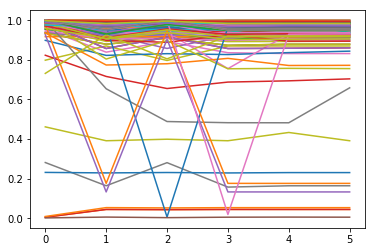

In [421]:
a = plt.plot(Pmat.T)